### pyspark version of EDA-2 on larger dataset

In [1]:
%set_env OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES
import pyspark
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

env: OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES


### 0. load spark dataframe

In [2]:
spark = SparkSession \
        .builder \
        .appName('test-spark2') \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/15 16:37:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
!wc -l /Applications/spark-3.4.1-bin-hadoop3/work/sparkify_event_data.json

 26259199 /Applications/spark-3.4.1-bin-hadoop3/work/sparkify_event_data.json


In [4]:
df = spark.sql('''
    SELECT userId
    FROM json.`/Applications/spark-3.4.1-bin-hadoop3/work/sparkify_event_data.json`
''').repartition(2, 'userId')

In [ ]:
df.count()

In [5]:
userId = df.select('userId').drop_duplicates().toPandas()
userId

,userId
0,1563081
1,1222580
2,1605667
3,1032628
4,1901081
...,...
22273,1423170
22274,1364857
22275,1305498
22276,1759755


In [6]:
userId_selected = userId.sample(frac=0.1).userId.values
userId_selected = tuple(x for x in userId_selected)
userId_selected

('1904491',
 '1591503',
 '1420238',
 '1757861',
 '1832599',
 '1411211',
 '1499432',
 '1968879',
 '1317238',
 '1647174',
 '1960538',
 '1175811',
 '1697760',
 '1943689',
 '1489722',
 '1722801',
 '1854227',
 '1653379',
 '1671328',
 '1156256',
 '1844222',
 '1669084',
 '1807579',
 '1731531',
 '1966778',
 '1513870',
 '1612582',
 '1182510',
 '1888805',
 '1492140',
 '1995903',
 '1443032',
 '1160969',
 '1242586',
 '1482982',
 '1592279',
 '1836755',
 '1192621',
 '1570348',
 '1906797',
 '1123874',
 '1940463',
 '1304120',
 '1284300',
 '1258676',
 '1640881',
 '1596076',
 '1081214',
 '1127166',
 '1661342',
 '1212712',
 '1064175',
 '1342856',
 '1290524',
 '1945231',
 '1463115',
 '1698484',
 '1256244',
 '1183288',
 '1611542',
 '1560602',
 '1715296',
 '1825055',
 '1924677',
 '1139169',
 '1771882',
 '1663219',
 '1360720',
 '1139022',
 '1404353',
 '1051731',
 '1014529',
 '1437571',
 '1844719',
 '1221805',
 '1072213',
 '1777459',
 '1591584',
 '1769917',
 '1923309',
 '1321590',
 '1733398',
 '1120185',
 '17

In [98]:
df = spark.sql("SELECT * FROM json.`/Applications/spark-3.4.1-bin-hadoop3/work/sparkify_event_data.json` WHERE userId IN {userId_selected}", 
               userId_selected = userId_selected).repartition(2, 'userId').persist()

23/07/15 17:06:54 WARN CacheManager: Asked to cache already cached data.        


In [99]:
df.count()

2563052

In [ ]:
# it's better to select based on userId to avoid having users with very few session counts
# df = spark.sql('''
#                 SELECT *
#                 FROM json.`/Applications/spark-3.4.1-bin-hadoop3/work/sparkify_event_data.json`
#                 LIMIT 1000000
#                ''').repartition(2, 'userId').persist()

In [100]:
df.count() # the second time should be very fast

2563052

In [10]:
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


### 1. get rid of nan

#### 1.1 be careful about different counts, the dataframe.count include all NaN

In [11]:
df.select(F.col('artist').isNull()).count() # this count won't work

2563052

In [12]:
df.select(F.count(F.col('artist').isNull())).show() # this count won't work either

+-----------------------+
|count((artist IS NULL))|
+-----------------------+
|                2563052|
+-----------------------+



In [13]:
df.select(F.count(F.when(F.col('artist').isNull(),1))).show() # F.count won't include nan

+--------------------------------------------+
|count(CASE WHEN (artist IS NULL) THEN 1 END)|
+--------------------------------------------+
|                                      465696|
+--------------------------------------------+



In [14]:
df.select(F.sum(F.isnull('artist').cast(ShortType()))).show() # sum can't be on bool type

+---------------------------------------+
|sum(CAST((artist IS NULL) AS SMALLINT))|
+---------------------------------------+
|                                 465696|
+---------------------------------------+



In [15]:
df.groupby('page').agg(F.count('*'), F.count('artist')).show() # count * vs count

+--------------------+--------+-------------+
|                page|count(1)|count(artist)|
+--------------------+--------+-------------+
|              Cancel|     493|            0|
|    Submit Downgrade|     641|            0|
|         Thumbs Down|   24282|            0|
|                Home|   93362|            0|
|           Downgrade|   18278|            0|
|         Roll Advert|   39089|            0|
|              Logout|   29796|            0|
|       Save Settings|    2894|            0|
|Cancellation Conf...|     493|            0|
|               About|    4720|            0|
|            Settings|   14724|            0|
|     Add to Playlist|   60435|            0|
|          Add Friend|   38308|            0|
|            NextSong| 2097356|      2097356|
|           Thumbs Up|  116263|            0|
|                Help|   12998|            0|
|             Upgrade|    4931|            0|
|               Error|    2507|            0|
|      Submit Upgrade|    1482|   

#### 1.2 then there're col.isNull, F.isnull, F.isnan, also needs to check str=='', F.isnan is somewhat slow

In [16]:
df.select(F.count(F.when(F.col('artist').isNull(), 1))).show()

+--------------------------------------------+
|count(CASE WHEN (artist IS NULL) THEN 1 END)|
+--------------------------------------------+
|                                      465696|
+--------------------------------------------+



In [17]:
df.select(F.count(F.when(F.isnull('artist'), 1))).show()

+--------------------------------------------+
|count(CASE WHEN (artist IS NULL) THEN 1 END)|
+--------------------------------------------+
|                                      465696|
+--------------------------------------------+



In [18]:
df.select(F.count(F.when(F.isnan('artist'), 1))).show() # nan is not null

+-----------------------------------------+
|count(CASE WHEN isnan(artist) THEN 1 END)|
+-----------------------------------------+
|                                        0|
+-----------------------------------------+



In [19]:
df.select([F.count(F.when(F.col(c)=='',1)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
df.select([F.count(F.when(F.isnull(c),1)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,465696,0,0,0,0,0,465696,0,0,0,0,0,0,465696,0,0,0,0


In [21]:
df.select([F.count(F.when(F.isnan(c),1)).alias(c) for c in df.columns]).toPandas() # this is somewhat slow

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
df.filter(F.isnull(df.firstName)).head(5)

[]

In [23]:
def value_counts(df, col):
    return df.groupby(col).count().sort(F.col('count').desc())

In [24]:
value_counts(df, 'userId').show()

+-------+-----+
| userId|count|
+-------+-----+
|1165912|11094|
|1620250|11073|
|1116029| 9148|
|1359870| 8147|
|1782082| 8061|
|1637236| 7978|
|1893294| 7829|
|1191239| 7813|
|1414878| 7572|
|1055294| 7481|
|1456278| 7394|
|1883693| 7381|
|1287354| 7271|
|1200578| 7086|
|1791648| 6946|
|1948990| 6933|
|1334917| 6931|
|1130196| 6858|
|1232692| 6549|
|1006980| 6387|
+-------+-----+
only showing top 20 rows



In [25]:
tmp = df.groupby('userId').agg(F.spark_partition_id()).toPandas()

In [26]:
tmp['SPARK_PARTITION_ID()'].value_counts()

SPARK_PARTITION_ID()
0    1116
1    1112
Name: count, dtype: int64

#### so for the larger dataset, userId==1261737 is logged out; if selected using random userId, it may not select this userId

In [27]:
def num_nulls(df, col, empty_str=False):
    if empty_str:
        return df.select(F.count(F.when(F.col(col)=='1261737', 1)).alias(f"num_nulls_{col}"))
    else:
        return df.select(F.count(F.when(F.isnull(col), 1)).alias(f"num_nulls_{col}"))

In [28]:
num_nulls(df, 'artist').show()

+----------------+
|num_nulls_artist|
+----------------+
|          465696|
+----------------+



In [29]:
num_nulls(df, 'userId', empty_str=True).show()

+----------------+
|num_nulls_userId|
+----------------+
|               0|
+----------------+



In [30]:
def expand_cols(df, func):
    ''' apply func on all columns of df then concat to pd '''
    return pd.concat([func(df, c).toPandas() for c in df.columns], axis=1)

In [31]:
expand_cols(df, num_nulls).T

,0
num_nulls_artist,465696
num_nulls_auth,0
num_nulls_firstName,0
num_nulls_gender,0
num_nulls_itemInSession,0
num_nulls_lastName,0
num_nulls_length,465696
num_nulls_level,0
num_nulls_location,0
num_nulls_method,0


#### removed this userId

In [101]:
df = df.filter(F.col('userId') != '1261737')
df.count()

2563052

In [33]:
value_counts(df, 'page').show(truncate=False)

+-------------------------+-------+
|page                     |count  |
+-------------------------+-------+
|NextSong                 |2097356|
|Thumbs Up                |116263 |
|Home                     |93362  |
|Add to Playlist          |60435  |
|Roll Advert              |39089  |
|Add Friend               |38308  |
|Logout                   |29796  |
|Thumbs Down              |24282  |
|Downgrade                |18278  |
|Settings                 |14724  |
|Help                     |12998  |
|Upgrade                  |4931   |
|About                    |4720   |
|Save Settings            |2894   |
|Error                    |2507   |
|Submit Upgrade           |1482   |
|Submit Downgrade         |641    |
|Cancel                   |493    |
|Cancellation Confirmation|493    |
+-------------------------+-------+



In [34]:
df.filter(F.isnull('artist')).select('page').drop_duplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [35]:
def sp_nunique(df, col):
    return df.select(F.count_distinct(col).alias(f"nunique_{col}"))

In [36]:
sp_nunique(df, 'page').show()

+------------+
|nunique_page|
+------------+
|          19|
+------------+



In [37]:
expand_cols(df, sp_nunique)

,nunique_artist,nunique_auth,nunique_firstName,nunique_gender,nunique_itemInSession,nunique_lastName,nunique_length,nunique_level,nunique_location,nunique_method,nunique_page,nunique_registration,nunique_sessionId,nunique_song,nunique_status,nunique_ts,nunique_userAgent,nunique_userId
0,29657,2,1223,2,1424,726,20337,2,476,2,19,2228,28576,149212,3,2000064,85,2228


In [38]:
value_counts(df, 'auth').show()

+---------+-------+
|     auth|  count|
+---------+-------+
|Logged In|2562559|
|Cancelled|    493|
+---------+-------+



In [39]:
value_counts(df, 'level').show()

+-----+-------+
|level|  count|
+-----+-------+
| paid|2020134|
| free| 542918|
+-----+-------+



In [40]:
tmp = df.filter('userId = 1000182').sort('ts')
print(tmp.head(1))
print(tmp.tail(1))

[]


[]


In [41]:
df.orderBy('userId','ts').groupby('userId').agg(F.first('level'), F.last('level')).show()

+-------+------------+-----------+
| userId|first(level)|last(level)|
+-------+------------+-----------+
|1000194|        free|       free|
|1000353|        paid|       paid|
|1001207|        paid|       paid|
|1001725|        free|       paid|
|1001759|        free|       paid|
|1002143|        free|       paid|
|1002409|        free|       paid|
|1002712|        free|       free|
|1003888|        paid|       paid|
|1004827|        free|       paid|
|1004998|        free|       free|
|1005096|        paid|       paid|
|1005442|        free|       paid|
|1005694|        paid|       paid|
|1006092|        free|       free|
|1006451|        free|       paid|
|1006980|        free|       paid|
|1007340|        free|       paid|
|1007956|        free|       paid|
|1008579|        free|       paid|
+-------+------------+-----------+
only showing top 20 rows



In [42]:
value_counts(df, 'status').show()

+------+-------+
|status|  count|
+------+-------+
|   200|2346386|
|   307| 214159|
|   404|   2507|
+------+-------+



In [43]:
value_counts(df.filter('status = 404'), 'page').show()

+-----+-----+
| page|count|
+-----+-----+
|Error| 2507|
+-----+-----+



In [44]:
value_counts(df, 'method').show()

+------+-------+
|method|  count|
+------+-------+
|   PUT|2371950|
|   GET| 191102|
+------+-------+



### 2. define churn event

In [102]:
df = df.withColumn('churn', F.when(F.col('page')=='Cancellation Confirmation', 1).otherwise(0))

In [103]:
window = Window.partitionBy('userId').orderBy('ts').rowsBetween(-1, 1)
df = df.withColumn('near_churn', F.max('churn').over(window))

In [104]:
value_counts(df, 'near_churn').show()

+----------+-------+
|near_churn|  count|
+----------+-------+
|         0|2562066|
|         1|    986|
+----------+-------+



In [105]:
df.filter("near_churn = 1").select('userId','page','ts').show(truncate=False)

+-------+-------------------------+-------------+
|userId |page                     |ts           |
+-------+-------------------------+-------------+
|1002712|Cancel                   |1543195637000|
|1002712|Cancellation Confirmation|1543195674000|
|1005442|Cancel                   |1538892474000|
|1005442|Cancellation Confirmation|1538892478000|
|1006451|Cancel                   |1543615312000|
|1006451|Cancellation Confirmation|1543615320000|
|1007340|Cancel                   |1540721113000|
|1007340|Cancellation Confirmation|1540721169000|
|1009571|Cancel                   |1542251525000|
|1009571|Cancellation Confirmation|1542251529000|
|1010184|Cancel                   |1541197257000|
|1010184|Cancellation Confirmation|1541197454000|
|1021740|Cancel                   |1540093701000|
|1021740|Cancellation Confirmation|1540093731000|
|1035710|Cancel                   |1540435963000|
|1035710|Cancellation Confirmation|1540435978000|
|1036943|Cancel                   |1543209532000|


In [106]:
df_feats = df.groupby('userId').agg(F.max('churn').alias('churn')).toPandas()

In [107]:
df_feats

,userId,churn
0,1222580,1
1,1199968,0
2,1122089,0
3,1418529,1
4,1957869,0
...,...,...
2223,1649197,0
2224,1087484,0
2225,1160957,0
2226,1364857,0


In [108]:
df_feats.churn.mean()

0.22127468581687612

In [109]:
df.filter(df.userId=='1827199').select('userId','page','churn','near_churn','ts').tail(10)

[]

#### so indeed cancellation confirmation happens right after cancle

In [110]:
window = Window.partitionBy('userId').orderBy('ts').rowsBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn('churn_yet', F.max('churn').over(window))

In [111]:
#filter up to churn_yet == 0
df.filter('churn_yet = 0').count()

2562559

In [112]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn',
 'near_churn',
 'churn_yet']

In [113]:
value_counts(df.filter('status == 307'), 'page').show()

+----------------+------+
|            page| count|
+----------------+------+
|       Thumbs Up|116263|
|      Add Friend| 38308|
|          Logout| 29796|
|     Thumbs Down| 24282|
|   Save Settings|  2894|
|  Submit Upgrade|  1482|
|Submit Downgrade|   641|
|          Cancel|   493|
+----------------+------+



#### make sure this cancel page is not leaked into the analysis

In [114]:
df = df.filter('(churn_yet = 0) AND (page != "Cancel")')

In [115]:
df.count()

2562066

### 3. make some features that stay the same over time

In [116]:
cols = df.columns
cols.remove('userId')
cols

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'churn',
 'near_churn',
 'churn_yet']

In [117]:
def get_static_features(df):
    return df.groupby('userId').agg(F.first('location').alias('location'),\
                                    F.first('userAgent').alias('agent'),\
                                    F.first('gender').alias('gender'),\
                                    F.first('registration').alias('registration')).toPandas()

In [118]:
tmp = get_static_features(df)
df_feats = pd.merge(df_feats, tmp, on='userId')

In [119]:
df_feats

,userId,churn,location,agent,gender,registration
0,1222580,1,"Watertown, SD","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",M,1534386660000
1,1199968,0,"Albany, OR",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,F,1537888532000
2,1122089,0,"Chicago-Naperville-Elgin, IL-IN-WI","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",F,1536788636000
3,1418529,1,"Phoenix-Mesa-Scottsdale, AZ",Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,F,1537558053000
4,1957869,0,"San Jose-Sunnyvale-Santa Clara, CA",Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,F,1528209119000
...,...,...,...,...,...,...
2223,1649197,0,"Washington-Arlington-Alexandria, DC-VA-MD-WV","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",F,1541847315000
2224,1087484,0,"Chico, CA",Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,F,1536710357000
2225,1160957,0,"Allentown-Bethlehem-Easton, PA-NJ",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,M,1537352245000
2226,1364857,0,"Los Angeles-Long Beach-Anaheim, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,M,1536886246000


In [ ]:
# for referece, this is how to do it in pyspark side
# def convert_agent(c):
#     return F.when(F.col(c).contains('macintosh'), 'mac').\
#              when(F.col(c).contains('iphone'), 'iphone').\
#              when(F.col(c).contains('ipad'), 'ipad').\
#              when(F.col(c).contains('windows'), 'windows').\
#              when(F.col(c).contains('linux'), 'linux').\
#              otherwise('others')

In [120]:
def stack_and_ready_for_plot(df):
    num_cols = list(df.dtypes.index[df.dtypes != 'object'])
    df = df[num_cols]
    tmp = df.drop(columns=['churn']).stack().reset_index()
    tmp.columns = ['userId','parameter','val']
    tmp = tmp.join(df[['churn']], on='userId')
    return tmp

In [121]:
def convert_agent(x):
    x = x.lower()
    if 'macintosh' in x:
        return 'mac'
    elif 'iphone' in x:
        return 'iphone'
    elif 'ipad' in x:
        return 'ipad'
    elif 'windows' in x:
        return 'windows'
    elif 'linux' in x:
        return 'linux'
    else:
        return 'others'

In [122]:
df_feats['agent'] = df_feats.agent.apply(convert_agent)

In [66]:
# registration_min = df_feats.registration.min()
# df_feats['registration'] = (df_feats['registration'] - registration_min)/3600/1000

<Axes: xlabel='val', ylabel='parameter'>

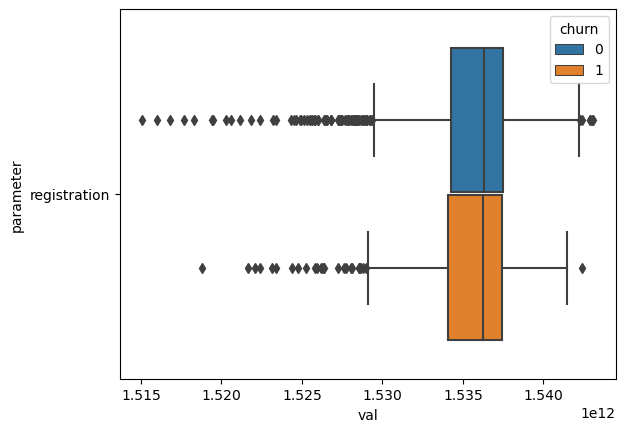

In [123]:
tmp = stack_and_ready_for_plot(df_feats)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')

<Axes: xlabel='agent', ylabel='Density'>

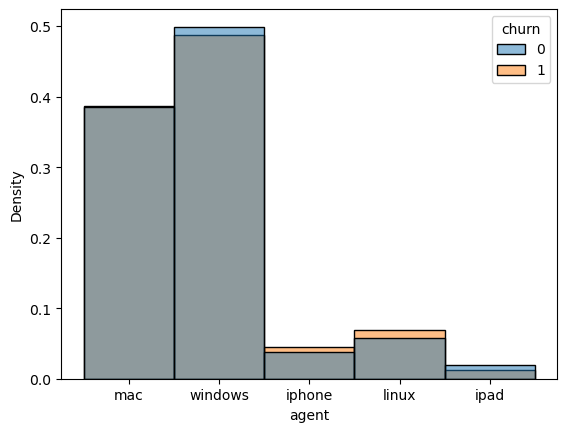

In [124]:
sns.histplot(df_feats, x='agent', hue='churn', common_norm=False, stat='density')

<Axes: xlabel='gender', ylabel='Density'>

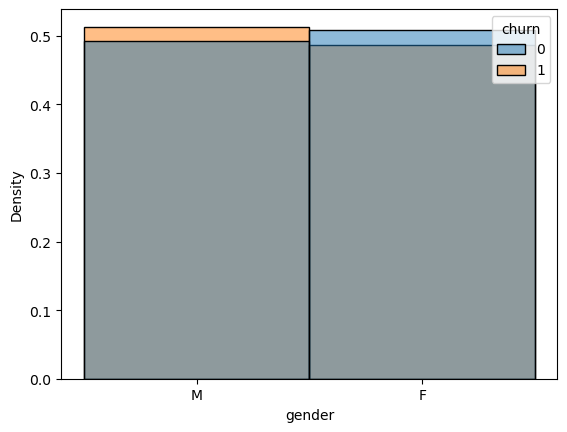

In [125]:
sns.histplot(df_feats, x='gender', hue='churn', common_norm=False, stat='density')

#### now this is similar to the smaller dataset!

### 4. get some features on page activity

In [126]:
actions = [x['page'] for x in df.select('page').distinct().collect()]
# actions.remove('Cancel')
actions

['Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [71]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn',
 'near_churn',
 'churn_yet']

In [72]:
def get_features(df):
    # get the total session time
    output = df.groupby('userId','sessionId').agg(((F.max('ts')-F.min('ts'))/3600/1000).alias('hour')).\
                groupby('userId').agg(F.sum('hour').alias('total_session_time')).toPandas()
    
    # total page actions
    g = df.groupby('userId')
    tmp = g.agg(*[F.sum(F.when(F.col('page')==action, 1)).alias(action) for action in actions],
                  F.count_distinct('sessionId').alias('session_counts'),
                  F.count_distinct('artist').alias('number_artist'),
                  F.count_distinct('song').alias('number_song'),
                  F.count(F.when(F.col('status')==307, 1)).alias('status_307_count'),
                  F.count(F.when(F.col('method')=='GET', 1)).alias('get_count'),
                  F.count('*').alias('count'),
                  ((F.max('ts')-F.min('ts'))/3600/1000).alias('total_time')).na.fill(0).toPandas()
    output = pd.merge(output, tmp, on='userId')
    
    # avg gap time
    output['avg_gap_time'] = (output['total_time'] - output['total_session_time']) / (output['session_counts'] - 1)
    output.loc[output.session_counts==1, 'avg_gap_time'] = 0.0
    
    # first and last level
    tmp = df.orderBy('userId','ts').groupby('userId').agg(F.first('level').alias('first_level'),
                                                          F.last('level').alias('last_level')).toPandas()
    output = pd.merge(output, tmp, on='userId')
    
    
#     # normalized by session_counts
#     for action in actions:
#         output[f"{action}_per_session"] = output[action] / output['session_counts']
#     output['time_per_session'] = output['total_session_time'] / output['session_counts']
    
#     # normalized by total time
#     for action in actions:
#         output[f"{action}_per_hour"] = output[action] / output['total_time']
#         output[f"{action}_per_session_hour"] = output[action] / output['total_session_time']
    
#     # duration is useful?
#     tmp = df.filter('page == "NextSong"').groupby('userId').agg((F.sum('length')/3600).alias('total_duration')).toPandas()
#     output = pd.merge(output, tmp, on='userId')
#     output['duration_per_session'] = output['total_duration'] / output['session_counts']
#     output['duration_per_hour'] = output['total_duration'] / output['total_time']
#     output['duration_per_session_hour'] = output['total_duration'] / output['total_session_time']    

    return output

In [73]:
tmp = get_features(df)
tmp

23/07/15 16:56:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/07/15 16:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/15 16:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/15 16:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/15 16:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/15 16:56:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/15 16:56:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/15 16:56:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2

,userId,total_session_time,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,About,...,session_counts,number_artist,number_song,status_307_count,get_count,count,total_time,avg_gap_time,first_level,last_level
0,1001759,3.914722,0,1,4,0,3,0,0,0,...,1,55,56,6,9,73,3.914722,0.000000,free,paid
1,1002712,37.578056,1,16,29,1,26,11,0,1,...,12,463,530,76,76,722,1326.760556,117.198409,free,free
2,1005096,33.992222,0,6,18,8,0,4,0,2,...,5,430,485,50,29,597,827.140278,198.287014,paid,paid
3,1005442,53.205556,0,3,33,10,3,12,0,2,...,7,616,727,91,57,939,122.819167,11.602269,free,paid
4,1006451,70.845833,0,9,43,11,14,8,2,1,...,10,784,957,72,92,1239,336.237500,29.487963,free,paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,1994083,77.227778,0,12,36,9,0,9,1,3,...,8,864,1043,96,60,1325,645.826111,81.228333,paid,paid
2224,1995903,26.880000,1,4,23,2,22,9,3,1,...,8,337,379,65,63,526,1298.066389,181.598056,free,free
2225,1998502,20.683611,1,5,27,5,4,13,0,1,...,12,277,298,44,43,408,1285.084722,114.945556,free,free
2226,1998774,81.424167,0,18,52,11,2,14,0,1,...,12,871,1081,111,83,1419,1410.296667,120.806591,free,paid


In [74]:
tmp.min()

userId                1000194
total_session_time        0.0
Submit Downgrade            0
Thumbs Down                 0
Home                        0
Downgrade                   0
Roll Advert                 0
Logout                      0
Save Settings               0
About                       0
Settings                    0
Add to Playlist             0
Add Friend                  0
NextSong                    0
Thumbs Up                   0
Help                        0
Upgrade                     0
Error                       0
Submit Upgrade              0
session_counts              1
number_artist               0
number_song                 0
status_307_count            0
get_count                   0
count                       1
total_time                0.0
avg_gap_time              0.0
first_level              free
last_level               free
dtype: object

<Axes: >

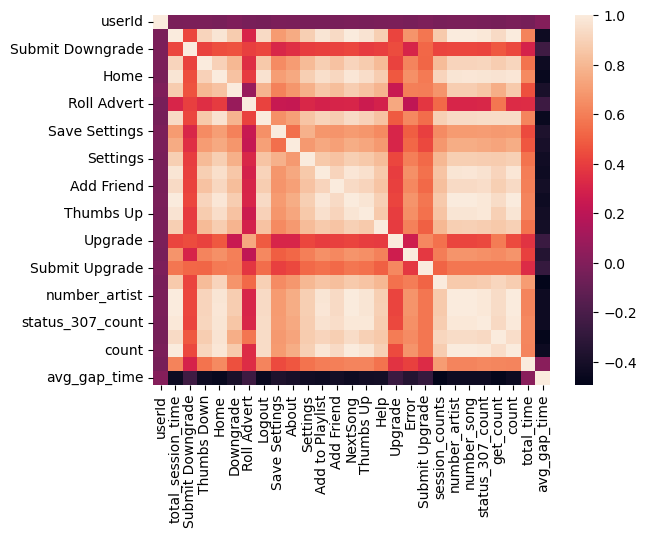

In [75]:
sns.heatmap(tmp.drop(columns=['first_level','last_level']).corr(method='spearman'))

#### there are a lot of correlations among parameters, need to better normalize them

In [76]:
df_feats_tmp = pd.merge(df_feats, tmp, on='userId')

In [77]:
cols = [x for x in df_feats_tmp.columns if 'per' not in x and x not in ['agent','gender','location', 'first_level', 'last_level']]
cols

['userId',
 'churn',
 'registration',
 'total_session_time',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'session_counts',
 'number_artist',
 'number_song',
 'status_307_count',
 'get_count',
 'count',
 'total_time',
 'avg_gap_time']

<Axes: >

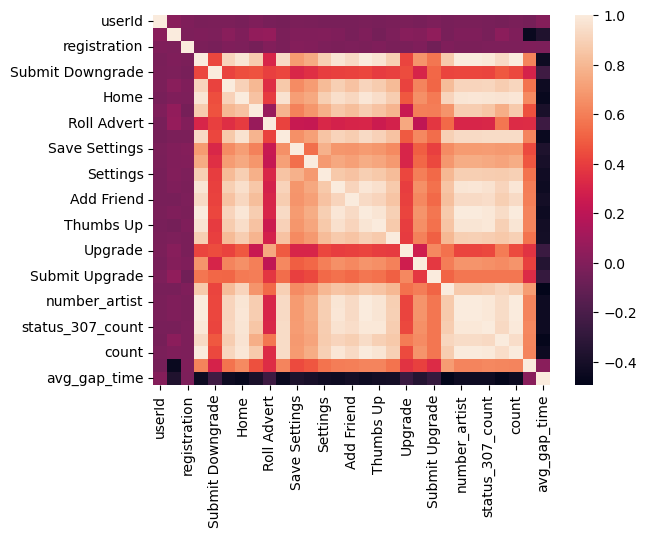

In [78]:
sns.heatmap(df_feats_tmp[cols].corr(method='spearman'))

In [79]:
df_feats_tmp.min()

userId                     1000194
churn                            0
location              Aberdeen, WA
agent                         ipad
gender                           F
registration                   0.0
total_session_time             0.0
Submit Downgrade                 0
Thumbs Down                      0
Home                             0
Downgrade                        0
Roll Advert                      0
Logout                           0
Save Settings                    0
About                            0
Settings                         0
Add to Playlist                  0
Add Friend                       0
NextSong                         0
Thumbs Up                        0
Help                             0
Upgrade                          0
Error                            0
Submit Upgrade                   0
session_counts                   1
number_artist                    0
number_song                      0
status_307_count                 0
get_count           

In [80]:
df_feats_tmp[cols].corrwith(df_feats_tmp.NextSong,method='spearman').sort_values()

avg_gap_time         -0.438550
userId               -0.027659
registration         -0.020339
churn                -0.012355
Roll Advert           0.310580
Upgrade               0.421995
Submit Downgrade      0.425962
Submit Upgrade        0.573039
total_time            0.616283
Error                 0.669524
Save Settings         0.692577
About                 0.755883
session_counts        0.871044
Downgrade             0.878613
Settings              0.887315
Help                  0.889391
Thumbs Down           0.909916
Logout                0.932779
Add Friend            0.932987
get_count             0.936332
Thumbs Up             0.973666
Home                  0.976693
Add to Playlist       0.976837
status_307_count      0.986364
total_session_time    0.997769
count                 0.999438
number_artist         0.999853
number_song           0.999961
NextSong              1.000000
dtype: float64

#### there's record for 0 nextsong, so looks like we need to normalize by count, give up total_duration, number_artist, number_song, nextsong

In [81]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn',
 'near_churn',
 'churn_yet']

In [127]:
def get_features(df):
    
    g = df.groupby('userId')
    
    # get the total session time
    output = df.groupby('userId','sessionId').agg(((F.max('ts')-F.min('ts'))/3600/1000).alias('hour')).\
                groupby('userId').agg(F.sum('hour').alias('total_session_time')).toPandas()
    
    # total time and page counts
    # also add registration to work harder on it
    tmp = g.agg(*[F.sum(F.when(F.col('page')==action, 1)).alias(action) for action in actions],
                  F.max('ts').alias('max_ts'),
                  F.min('ts').alias('min_ts'),
                  F.count_distinct('sessionId').alias('session_counts'),
                  F.count('*').alias('count'),
                  F.count(F.when(F.col('status')==307, 1)).alias('status_307_count'),   
                  F.count(F.when(F.col('method')=='GET', 1)).alias('get_count')).na.fill(0).toPandas()
    output = pd.merge(output, tmp, on='userId')
    output['total_time'] = (output['max_ts'] - output['min_ts'])/3600./1000.
    
    # gap time
    output['avg_gap_time'] = (output['total_time'] - output['total_session_time']) / (output['session_counts'] - 1)
    output.loc[output.session_counts==1, 'avg_gap_time'] = 0.0
    output.drop(columns=['total_session_time', 'session_counts'], inplace=True)
    
    # normalize by count
    for action in actions:
        if action != 'NextSong':
            output[action] = output[action] / output['count']
    output.drop(columns=['NextSong'], inplace=True)
    output['status_307_count'] = output['status_307_count'] / output['count']
    output['get_count'] = output['get_count'] / output['count']
    
    # first and last level
    tmp = df.orderBy('userId','ts').groupby('userId').agg(F.first('level').alias('first_level'),
                                                          F.last('level').alias('last_level')).toPandas()
    output = pd.merge(output, tmp, on='userId')    
    
    return output

In [128]:
tmp = get_features(df)
tmp

,userId,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,About,Settings,...,Submit Upgrade,max_ts,min_ts,count,status_307_count,get_count,total_time,avg_gap_time,first_level,last_level
0,1001759,0.000000,0.013699,0.054795,0.000000,0.041096,0.000000,0.000000,0.000000,0.013699,...,0.013699,1539261794000,1539247701000,73,0.082192,0.123288,3.914722,0.000000,free,paid
1,1002712,0.001385,0.022161,0.040166,0.001385,0.036011,0.015235,0.000000,0.001385,0.012465,...,0.001385,1543195636000,1538419298000,722,0.105263,0.105263,1326.760556,117.198409,free,free
2,1005096,0.000000,0.010050,0.030151,0.013400,0.000000,0.006700,0.000000,0.003350,0.000000,...,0.000000,1542252320000,1539274615000,597,0.083752,0.048576,827.140278,198.287014,paid,paid
3,1005442,0.000000,0.003195,0.035144,0.010650,0.003195,0.012780,0.000000,0.002130,0.005325,...,0.001065,1538892473000,1538450324000,939,0.096912,0.060703,122.819167,11.602269,free,paid
4,1006451,0.000000,0.007264,0.034705,0.008878,0.011299,0.006457,0.001614,0.000807,0.012107,...,0.000807,1543615311000,1542404856000,1239,0.058111,0.074253,336.237500,29.487963,free,paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,1994083,0.000000,0.009057,0.027170,0.006792,0.000000,0.006792,0.000755,0.002264,0.003019,...,0.000000,1541020831000,1538695857000,1325,0.072453,0.045283,645.826111,81.228333,paid,paid
2224,1995903,0.001901,0.007605,0.043726,0.003802,0.041825,0.017110,0.005703,0.001901,0.013308,...,0.001901,1543278633000,1538605594000,526,0.123574,0.119772,1298.066389,181.598056,free,free
2225,1998502,0.002451,0.012255,0.066176,0.012255,0.009804,0.031863,0.000000,0.002451,0.007353,...,0.002451,1543448889000,1538822584000,408,0.107843,0.105392,1285.084722,114.945556,free,free
2226,1998774,0.000000,0.012685,0.036646,0.007752,0.001409,0.009866,0.000000,0.000705,0.002819,...,0.000705,1543483535000,1538406467000,1419,0.078224,0.058492,1410.296667,120.806591,free,paid


In [129]:
df_feats_tmp = pd.merge(df_feats, tmp, on='userId')

In [134]:
df_feats_tmp['max_ts_since_register'] = (df_feats_tmp['max_ts'] - df_feats_tmp['registration'])/3600./1000.
df_feats_tmp['min_ts_since_register'] = (df_feats_tmp['min_ts'] - df_feats_tmp['registration'])/3600./1000.

In [135]:
df_feats_tmp.columns

Index(['userId', 'churn', 'location', 'agent', 'gender', 'registration',
       'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert',
       'Logout', 'Save Settings', 'About', 'Settings', 'Add to Playlist',
       'Add Friend', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade',
       'max_ts', 'min_ts', 'count', 'status_307_count', 'get_count',
       'total_time', 'avg_gap_time', 'first_level', 'last_level',
       'max_ts_since_register', 'min_ts_since_register'],
      dtype='object')

(0.0, 0.2)

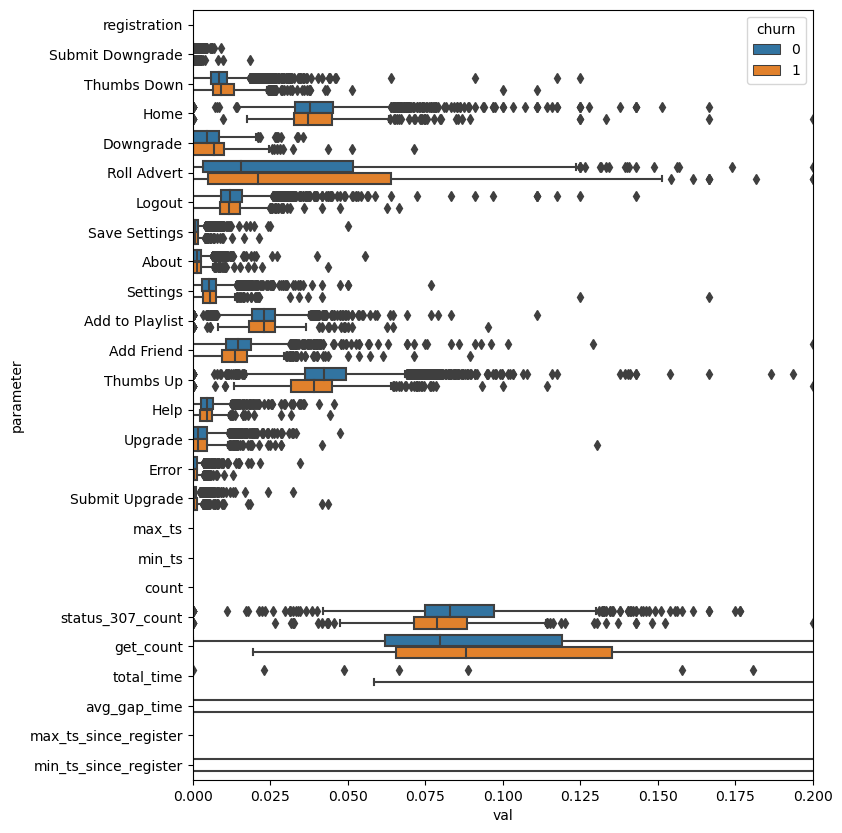

In [136]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([0,0.2])

(1520000000000.0, 1560000000000.0)

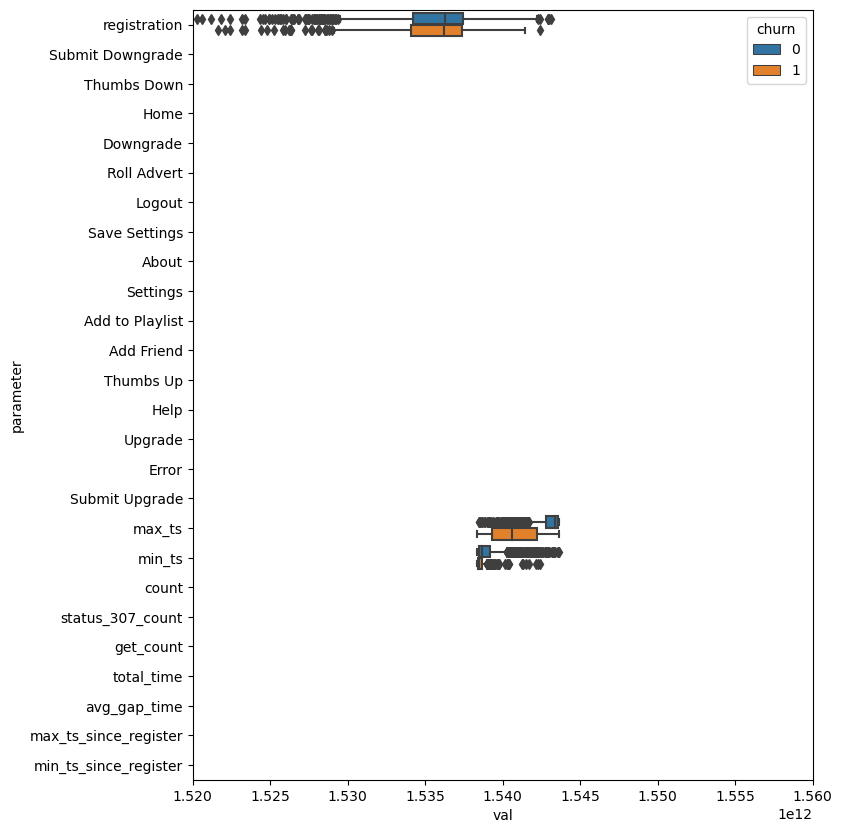

In [140]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([1.52e12,1.56e12])

(0.0, 2000.0)

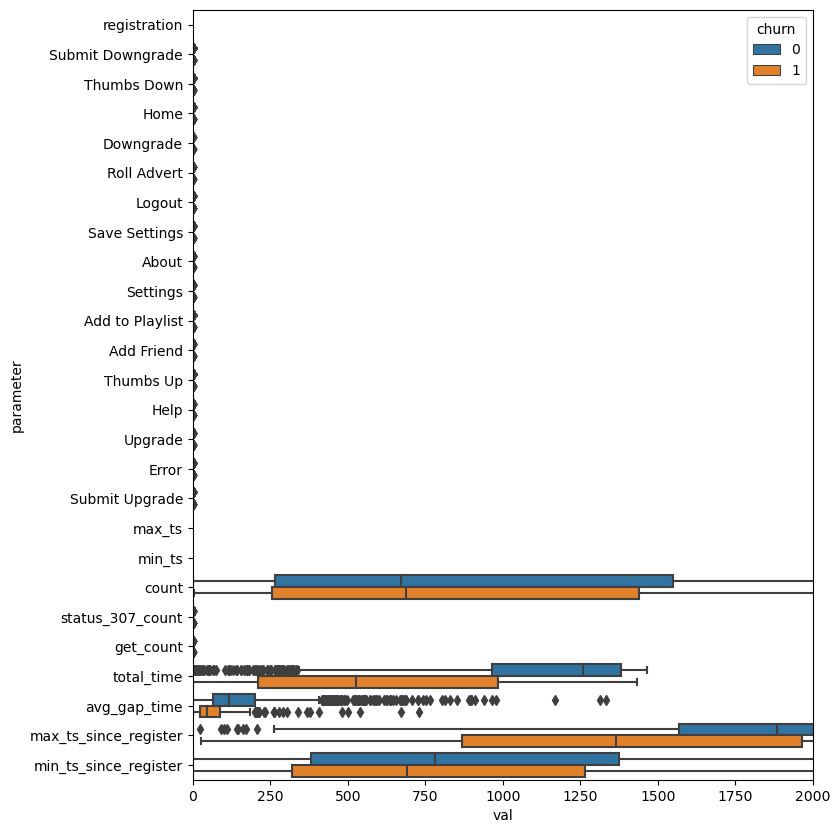

In [143]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([0,2000])

#### with random userId, this is much closer to smaller dataset

<Axes: >

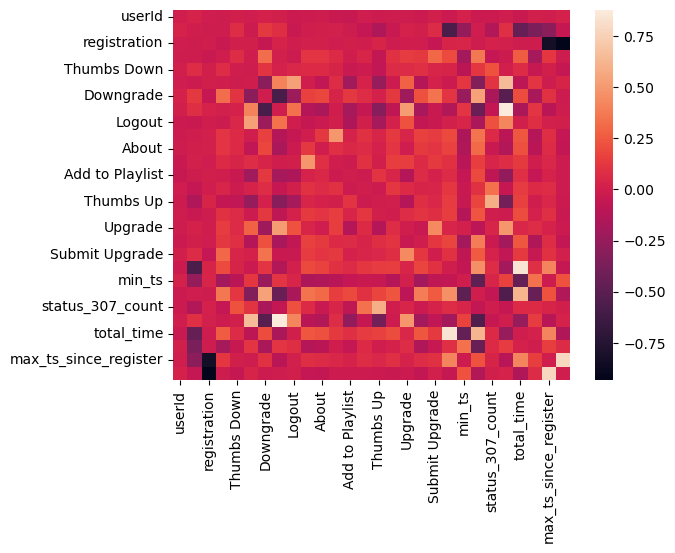

In [144]:
tmp = df_feats_tmp.drop(columns=['location','gender','agent','first_level','last_level']).corr(method='spearman')
for i in range(tmp.shape[0]):
    tmp.iloc[i,i] = 0.0
sns.heatmap(tmp)

In [145]:
df_feats_tmp['userId_num'] = df_feats_tmp['userId'].astype(float)/1e+6

In [146]:
df_feats_tmp.drop(columns=['location', 'agent','gender','userId']).corrwith(df_feats_tmp.churn, method='spearman').sort_values()

max_ts                  -0.574005
total_time              -0.452365
avg_gap_time            -0.367100
max_ts_since_register   -0.301737
min_ts                  -0.256322
Thumbs Up               -0.151310
status_307_count        -0.137105
Add Friend              -0.061465
min_ts_since_register   -0.049756
Logout                  -0.037011
Help                    -0.034502
Home                    -0.020588
registration            -0.019897
Submit Downgrade        -0.013981
Add to Playlist         -0.013828
count                   -0.010336
Save Settings           -0.003696
About                    0.001371
first_level              0.006644
Error                    0.007862
Settings                 0.012269
Upgrade                  0.017055
userId_num               0.023587
Submit Upgrade           0.067881
last_level               0.074427
Thumbs Down              0.077283
Roll Advert              0.080215
get_count                0.090246
Downgrade                0.127057
churn         

In [149]:
df_feats_tmp[['max_ts','total_time','max_ts_since_register','registration','min_ts_since_register']].corr()

,max_ts,total_time,max_ts_since_register,registration,min_ts_since_register
max_ts,1.000000,0.844520,0.405513,0.020614,-0.009864
total_time,0.844520,1.000000,0.384781,-0.028876,-0.114348
max_ts_since_register,0.405513,0.384781,1.000000,-0.905536,0.872955
registration,0.020614,-0.028876,-0.905536,1.000000,-0.959375
min_ts_since_register,-0.009864,-0.114348,0.872955,-0.959375,1.000000


#### these are correlated, keep max_ts_since_registration, total_time, registration is enough

In [151]:
df_feats_tmp.drop(columns=['min_ts','min_ts_since_register'], inplace=True)

In [157]:
df_feats_tmp['registration_dt'] = pd.to_datetime(df_feats_tmp['registration'], unit='ms')

In [159]:
df_feats_tmp['registration_dt'].min(), df_feats_tmp['registration_dt'].max()

(Timestamp('2018-01-04 14:13:12'), Timestamp('2018-11-24 18:32:28'))

In [161]:
df_feats_tmp['registration_month'] = df_feats_tmp['registration_dt'].apply(lambda x:x.month)

<Axes: xlabel='registration_month', ylabel='Density'>

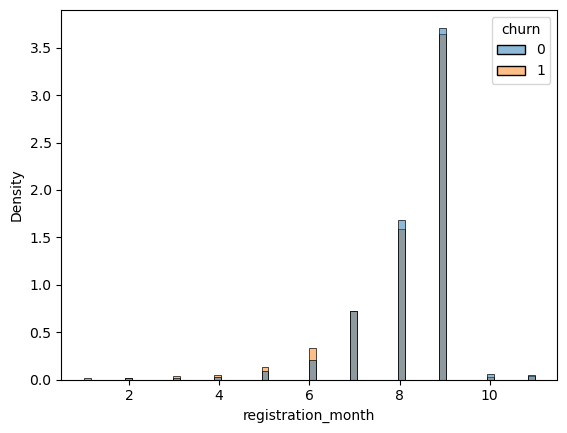

In [162]:
sns.histplot(df_feats_tmp, x='registration_month', hue='churn', common_norm=False, stat='density')

<Axes: xlabel='userId_num', ylabel='Density'>

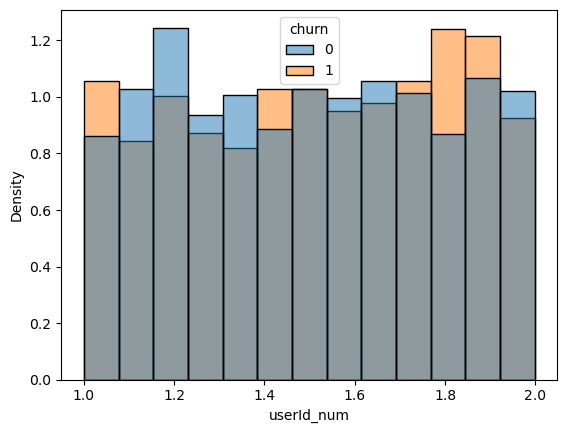

In [163]:
sns.histplot(df_feats_tmp, x='userId_num', hue='churn', common_norm=False, stat='density')

#### userId now looks pretty normal

In [164]:
df_feats_tmp.churn.mean()

0.22127468581687612

In [165]:
df_feats_tmp.groupby('agent').agg({'userId':'count', 'churn':'mean'})

,userId,churn
agent,,
ipad,40,0.150000
iphone,88,0.250000
linux,135,0.251852
mac,859,0.222352
windows,1106,0.216998


In [166]:
df_feats_tmp.groupby('gender').agg({'userId':'count', 'churn':'mean'})

,userId,churn
gender,,
F,1121,0.214095
M,1107,0.228546


In [167]:
df_feats_tmp.groupby('first_level').agg({'userId':'count', 'churn':'mean'})

,userId,churn
first_level,,
free,1702,0.219741
paid,526,0.226236


In [168]:
df_feats_tmp.groupby('last_level').agg({'userId':'count', 'churn':'mean'})

,userId,churn
last_level,,
free,861,0.182346
paid,1367,0.245794


In [170]:
df_feats_tmp.groupby('registration_month').agg({'userId':'count', 'churn':'mean'})

,userId,churn
registration_month,,
1,3,0.000000
2,5,0.200000
3,8,0.375000
4,12,0.333333
5,34,0.294118
6,80,0.312500
7,244,0.221311
8,561,0.212121
9,1248,0.217949


In [171]:
df_feats_tmp['state'] = df_feats_tmp['location'].apply(lambda x: x.split(',')[1].split('-')[0])

In [172]:
df_feats_tmp.groupby('state').agg({'userId':'count', 'churn':'mean'})

,userId,churn
state,,
AK,5,0.200000
AL,32,0.125000
AR,24,0.291667
AZ,48,0.291667
CA,280,0.228571
CO,43,0.162791
CT,39,0.205128
DC,40,0.225000
FL,157,0.216561


#### maybe some variations in the state, but hard to tell

### 5. do some baseline random forest

In [173]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [174]:
df_feats_tmp.isna().sum()

userId                   0
churn                    0
location                 0
agent                    0
gender                   0
registration             0
Submit Downgrade         0
Thumbs Down              0
Home                     0
Downgrade                0
Roll Advert              0
Logout                   0
Save Settings            0
About                    0
Settings                 0
Add to Playlist          0
Add Friend               0
Thumbs Up                0
Help                     0
Upgrade                  0
Error                    0
Submit Upgrade           0
max_ts                   0
count                    0
status_307_count         0
get_count                0
total_time               0
avg_gap_time             0
first_level              0
last_level               0
max_ts_since_register    0
userId_num               0
registration_dt          0
registration_month       0
state                    0
dtype: int64

In [175]:
df_feats_tmp.head(5)

,userId,churn,location,agent,gender,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,...,get_count,total_time,avg_gap_time,first_level,last_level,max_ts_since_register,userId_num,registration_dt,registration_month,state
0,1222580,1,"Watertown, SD",mac,M,1534386660000,0.000925,0.007867,0.038408,0.007404,...,0.070338,719.289444,31.309912,paid,paid,1820.773611,1.222580,2018-08-16 02:31:00,8,SD
1,1199968,0,"Albany, OR",windows,F,1537888532000,0.000000,0.010758,0.028606,0.010513,...,0.057213,1456.609167,45.244599,free,paid,1585.354722,1.199968,2018-09-25 15:15:32,9,OR
2,1122089,0,"Chicago-Naperville-Elgin, IL-IN-WI",windows,F,1536788636000,0.000000,0.010000,0.031613,0.009355,...,0.056774,1457.560556,85.238222,paid,paid,1891.833611,1.122089,2018-09-12 21:43:56,9,IL
3,1418529,1,"Phoenix-Mesa-Scottsdale, AZ",windows,F,1537558053000,0.000000,0.008139,0.033679,0.010946,...,0.060904,995.279444,30.450150,free,paid,1215.827500,1.418529,2018-09-21 19:27:33,9,AZ
4,1957869,0,"San Jose-Sunnyvale-Santa Clara, CA",windows,F,1528209119000,0.000000,0.009714,0.035429,0.009714,...,0.058286,1447.609167,112.149514,paid,paid,4265.084722,1.957869,2018-06-05 14:31:59,6,CA


In [197]:
df_feats_tmp.describe().loc['mean']

churn                                         0.221275
registration                      1535384586131.059326
Submit Downgrade                              0.000255
Thumbs Down                                   0.010093
Home                                          0.042209
Downgrade                                     0.005466
Roll Advert                                    0.03141
Logout                                         0.01357
Save Settings                                 0.001228
About                                         0.002143
Settings                                      0.006101
Add to Playlist                               0.022467
Add Friend                                    0.015316
Thumbs Up                                     0.043764
Help                                           0.00496
Upgrade                                       0.003405
Error                                         0.000982
Submit Upgrade                                0.000874
max_ts    

In [201]:
# reduce the range for registration and max_ts
registration_min = df_feats_tmp['registration'].min()
df_feats_tmp['registration'] -= registration_min
df_feats_tmp['max_ts'] -= registration_min
df_feats_tmp['registration'] /= (3600*1000)
df_feats_tmp['max_ts'] /= (3600*1000)

In [205]:
df_model = pd.get_dummies(df_feats_tmp, columns=['agent', 'gender','first_level','last_level'], drop_first=True, dtype=int)
df_model.head(5)

,userId,churn,location,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,registration_dt,registration_month,state,agent_iphone,agent_linux,agent_mac,agent_windows,gender_M,first_level_paid,last_level_paid
0,1222580,1,"Watertown, SD",5364.296667,0.000925,0.007867,0.038408,0.007404,0.007867,0.011106,...,2018-08-16 02:31:00,8,SD,0,0,1,0,1,1,1
1,1199968,0,"Albany, OR",6337.038889,0.000000,0.010758,0.028606,0.010513,0.003912,0.009291,...,2018-09-25 15:15:32,9,OR,0,0,0,1,0,0,1
2,1122089,0,"Chicago-Naperville-Elgin, IL-IN-WI",6031.512222,0.000000,0.010000,0.031613,0.009355,0.000645,0.010968,...,2018-09-12 21:43:56,9,IL,0,0,0,1,0,1,1
3,1418529,1,"Phoenix-Mesa-Scottsdale, AZ",6245.239167,0.000000,0.008139,0.033679,0.010946,0.003929,0.011226,...,2018-09-21 19:27:33,9,AZ,0,0,0,1,0,0,1
4,1957869,0,"San Jose-Sunnyvale-Santa Clara, CA",3648.313056,0.000000,0.009714,0.035429,0.009714,0.001143,0.010286,...,2018-06-05 14:31:59,6,CA,0,0,0,1,0,1,1


In [206]:
X, y = df_model.drop(columns=['userId','churn', 'location', 'state', 'registration_dt']).values, df_model.churn.values
feats = df_model.drop(columns=['userId','churn', 'location', 'state', 'registration_dt']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [207]:
feats

Index(['registration', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade',
       'Roll Advert', 'Logout', 'Save Settings', 'About', 'Settings',
       'Add to Playlist', 'Add Friend', 'Thumbs Up', 'Help', 'Upgrade',
       'Error', 'Submit Upgrade', 'max_ts', 'count', 'status_307_count',
       'get_count', 'total_time', 'avg_gap_time', 'max_ts_since_register',
       'userId_num', 'registration_month', 'agent_iphone', 'agent_linux',
       'agent_mac', 'agent_windows', 'gender_M', 'first_level_paid',
       'last_level_paid'],
      dtype='object')

In [208]:
clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                   param_grid = {'min_samples_leaf':[1,2,5,7,10,20,30,40,50]},
                   cv = 5,
                   scoring = ['f1', 'roc_auc'],
                   refit = 'f1',
                   verbose = 3)

In [209]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END min_samples_leaf=1; f1: (test=0.776) roc_auc: (test=0.928) total time=   0.4s
[CV 2/5] END min_samples_leaf=1; f1: (test=0.800) roc_auc: (test=0.956) total time=   0.4s
[CV 3/5] END min_samples_leaf=1; f1: (test=0.763) roc_auc: (test=0.923) total time=   0.4s
[CV 4/5] END min_samples_leaf=1; f1: (test=0.742) roc_auc: (test=0.925) total time=   0.4s
[CV 5/5] END min_samples_leaf=1; f1: (test=0.863) roc_auc: (test=0.979) total time=   0.4s
[CV 1/5] END min_samples_leaf=2; f1: (test=0.800) roc_auc: (test=0.922) total time=   0.4s
[CV 2/5] END min_samples_leaf=2; f1: (test=0.819) roc_auc: (test=0.957) total time=   0.4s
[CV 3/5] END min_samples_leaf=2; f1: (test=0.783) roc_auc: (test=0.923) total time=   0.4s
[CV 4/5] END min_samples_leaf=2; f1: (test=0.794) roc_auc: (test=0.924) total time=   0.4s
[CV 5/5] END min_samples_leaf=2; f1: (test=0.840) roc_auc: (test=0.973) total time=   0.4s
[CV 1/5] END min_samples_leaf=

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_leaf': [1, 2, 5, 7, 10, 20, 30, 40, 50]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=3)

In [210]:
clf.best_params_

{'min_samples_leaf': 2}

In [211]:
clf.cv_results_

{'mean_fit_time': array([0.41442518, 0.38437157, 0.35846019, 0.33990798, 0.32522111,
        0.29755797, 0.27430334, 0.2559597 , 0.24223642]),
 'std_fit_time': array([0.01331312, 0.00533152, 0.00497211, 0.00728166, 0.00304846,
        0.00860378, 0.00897009, 0.00412647, 0.0047355 ]),
 'mean_score_time': array([0.02072883, 0.01954546, 0.01917143, 0.01875186, 0.01822147,
        0.0187458 , 0.01743426, 0.01720524, 0.01812463]),
 'std_score_time': array([0.00180628, 0.00054048, 0.00122578, 0.0010284 , 0.00081334,
        0.00090493, 0.00051314, 0.00035814, 0.00077883]),
 'param_min_samples_leaf': masked_array(data=[1, 2, 5, 7, 10, 20, 30, 40, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_leaf': 1},
  {'min_samples_leaf': 2},
  {'min_samples_leaf': 5},
  {'min_samples_leaf': 7},
  {'min_samples_leaf': 10},
  {'min_samples_leaf': 20},
  {'min_samples_l

In [212]:
f1_score(y_test, clf.predict(X_test))

0.797752808988764

In [213]:
def importance_plot(importance, cols, figsize=(10,20)):
    tmp = pd.DataFrame(importance.reshape(-1,1), index=cols)
    tmp.reset_index(inplace=True)
    tmp.columns = ('feature','importance')
    plt.figure(figsize = figsize)
    sns.barplot(data = tmp,
                x = 'importance',
                y = 'feature',
                order = tmp.sort_values(by='importance').feature)

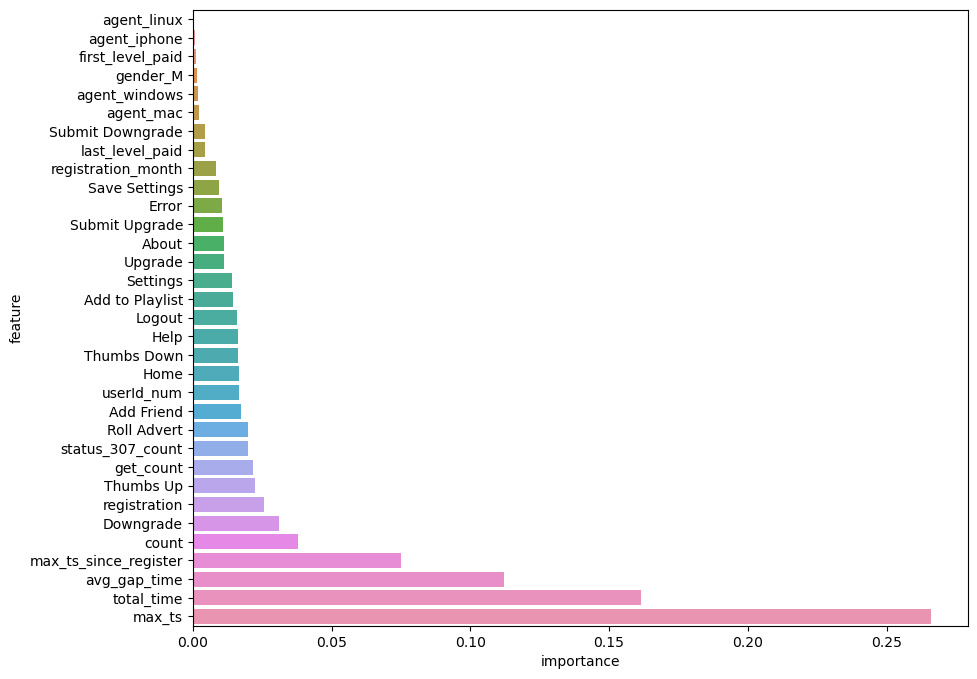

In [214]:
importance_plot(clf.best_estimator_.feature_importances_, feats, figsize=(10,8))

#### this may not be accurate

In [215]:
from sklearn.preprocessing import PowerTransformer

In [216]:
pipeline = Pipeline([
    ('preprocess', PowerTransformer()),
    ('clf', LogisticRegression(class_weight='balanced'))
])

In [217]:
clf = GridSearchCV(pipeline,
                   param_grid = {'clf__C':[1e-2,1e-1,1.0,5.0,10.0,20.0,50.0]},
                   cv = 5,
                   scoring = ['f1', 'roc_auc'],
                   refit = 'f1',
                   verbose = 3)

In [218]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END clf__C=0.01; f1: (test=0.776) roc_auc: (test=0.921) total time=   0.1s
[CV 2/5] END clf__C=0.01; f1: (test=0.814) roc_auc: (test=0.944) total time=   0.1s
[CV 3/5] END clf__C=0.01; f1: (test=0.739) roc_auc: (test=0.912) total time=   0.1s
[CV 4/5] END clf__C=0.01; f1: (test=0.721) roc_auc: (test=0.914) total time=   0.1s
[CV 5/5] END clf__C=0.01; f1: (test=0.804) roc_auc: (test=0.968) total time=   0.1s
[CV 1/5] END clf__C=0.1; f1: (test=0.769) roc_auc: (test=0.929) total time=   0.1s
[CV 2/5] END clf__C=0.1; f1: (test=0.800) roc_auc: (test=0.949) total time=   0.1s
[CV 3/5] END clf__C=0.1; f1: (test=0.771) roc_auc: (test=0.926) total time=   0.1s
[CV 4/5] END clf__C=0.1; f1: (test=0.736) roc_auc: (test=0.918) total time=   0.1s
[CV 5/5] END clf__C=0.1; f1: (test=0.775) roc_auc: (test=0.973) total time=   0.1s
[CV 1/5] END clf__C=1.0; f1: (test=0.761) roc_auc: (test=0.927) total time=   0.1s
[CV 2/5] END clf__C=1.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', PowerTransformer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'clf__C': [0.01, 0.1, 1.0, 5.0, 10.0, 20.0, 50.0]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=3)

In [219]:
clf.best_params_

{'clf__C': 0.01}

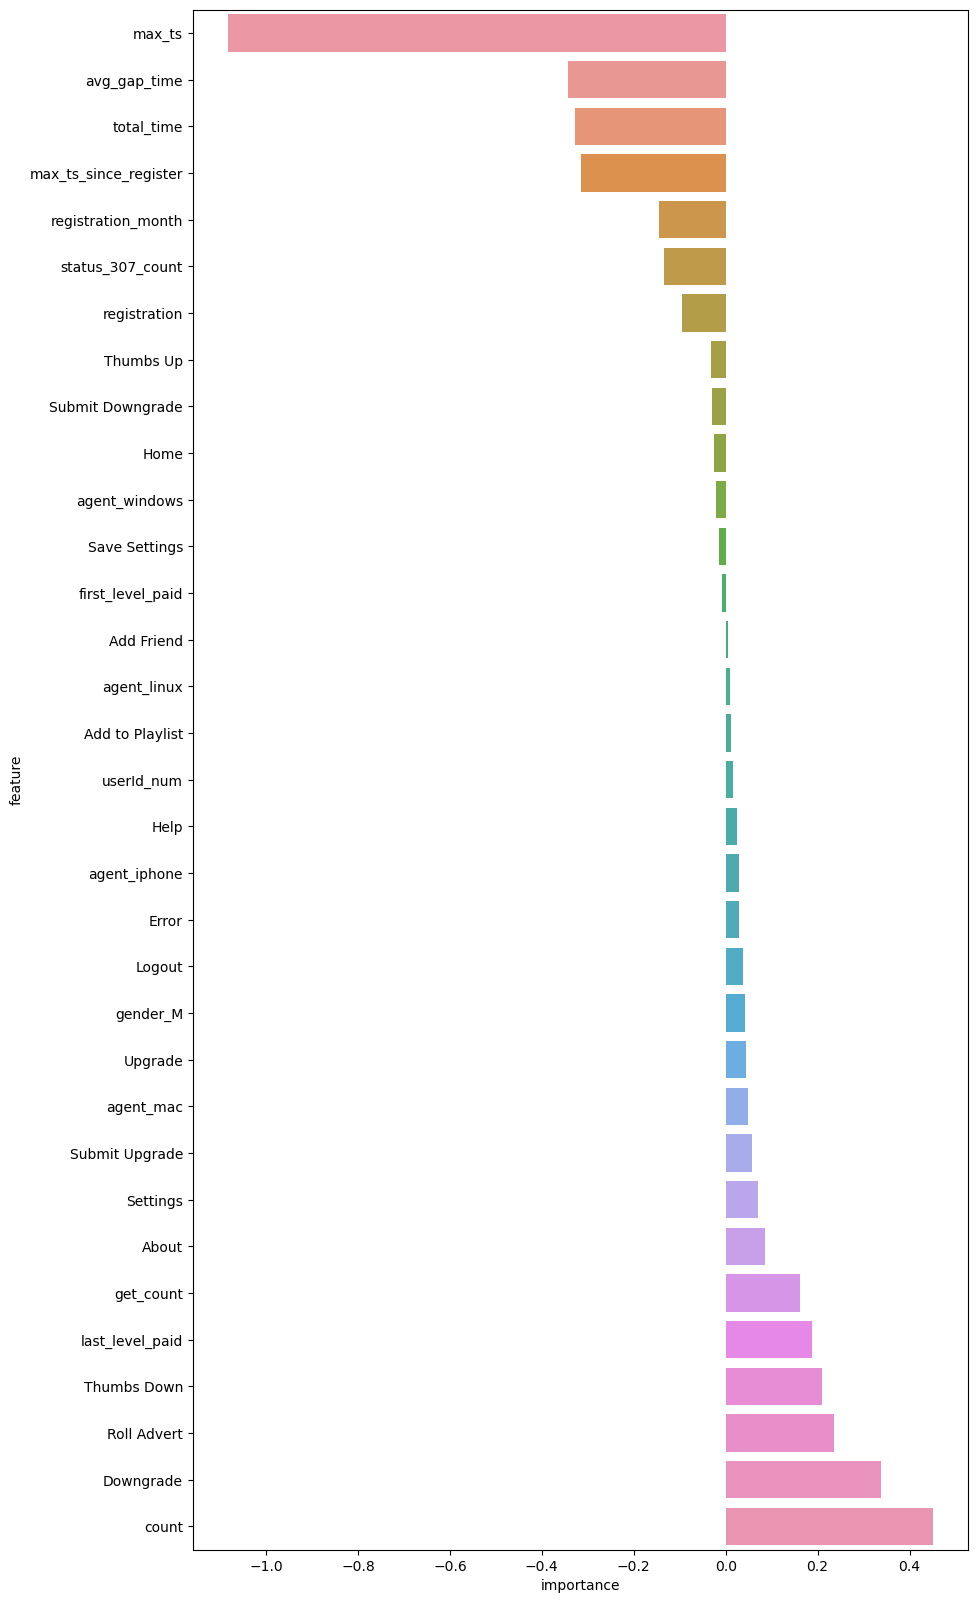

In [220]:
importance_plot(clf.best_estimator_[1].coef_, feats)

In [221]:
f1_score(clf.predict(X_test), y_test)

0.7692307692307692

### 6. do some time dependence?

In [222]:
window = Window.partitionBy('userId')
df = df.withColumn('recent', (0.8*F.max('ts').over(window)+0.2*F.min('ts').over(window)))

In [223]:
df.select(F.mean(F.when(F.col('ts')>F.col('recent'),1).otherwise(0))).show()

+----------------------------------------------+
|avg(CASE WHEN (ts > recent) THEN 1 ELSE 0 END)|
+----------------------------------------------+
|                           0.25387909601079756|
+----------------------------------------------+



In [224]:
df_recent = df.filter(F.col('ts')>F.col('recent'))

In [227]:
tmp = get_features(df_recent)
tmp = tmp.drop(columns=['first_level','last_level', 'total_time', 'max_ts', 'min_ts'])

In [228]:
tmp.columns

Index(['userId', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade',
       'Roll Advert', 'Logout', 'Save Settings', 'About', 'Settings',
       'Add to Playlist', 'Add Friend', 'Thumbs Up', 'Help', 'Upgrade',
       'Error', 'Submit Upgrade', 'count', 'status_307_count', 'get_count',
       'avg_gap_time'],
      dtype='object')

In [229]:
df_feats_tmp_change = pd.merge(df_feats_tmp, tmp, on='userId', suffixes=['','_recent'])
df_feats_tmp_change

,userId,churn,location,agent,gender,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,...,Add Friend_recent,Thumbs Up_recent,Help_recent,Upgrade_recent,Error_recent,Submit Upgrade_recent,count_recent,status_307_count_recent,get_count_recent,avg_gap_time_recent
0,1222580,1,"Watertown, SD",mac,M,5364.296667,0.000925,0.007867,0.038408,0.007404,...,0.022883,0.038902,0.006865,0.002288,0.002288,0.002288,437,0.068650,0.091533,33.713796
1,1199968,0,"Albany, OR",windows,F,6337.038889,0.000000,0.010758,0.028606,0.010513,...,0.026426,0.040334,0.006954,0.000000,0.001391,0.000000,719,0.090403,0.063978,62.893264
2,1122089,0,"Chicago-Naperville-Elgin, IL-IN-WI",windows,F,6031.512222,0.000000,0.010000,0.031613,0.009355,...,0.012270,0.049080,0.003681,0.000000,0.001227,0.000000,815,0.084663,0.050307,54.412361
3,1418529,1,"Phoenix-Mesa-Scottsdale, AZ",windows,F,6245.239167,0.000000,0.008139,0.033679,0.010946,...,0.012277,0.043527,0.002232,0.000000,0.000000,0.000000,896,0.082589,0.061384,25.588333
4,1957869,0,"San Jose-Sunnyvale-Santa Clara, CA",windows,F,3648.313056,0.000000,0.009714,0.035429,0.009714,...,0.018935,0.041420,0.007101,0.000000,0.000000,0.000000,845,0.082840,0.056805,59.913958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,1649197,0,"Washington-Arlington-Alexandria, DC-VA-MD-WV",mac,F,7436.700833,0.000000,0.018182,0.018182,0.000000,...,0.000000,0.074074,0.000000,0.000000,0.000000,0.000000,27,0.148148,0.111111,0.000000
2223,1087484,0,"Chico, CA",windows,F,6009.768056,0.000000,0.018868,0.018868,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000
2224,1160957,0,"Allentown-Bethlehem-Easton, PA-NJ",windows,M,6188.070278,0.000000,0.019231,0.057692,0.000000,...,0.000000,0.100000,0.000000,0.050000,0.000000,0.050000,20,0.150000,0.150000,0.000000
2225,1364857,0,"Los Angeles-Long Beach-Anaheim, CA",windows,M,6058.626111,0.000000,0.012903,0.070968,0.000000,...,0.020690,0.068966,0.006897,0.013793,0.000000,0.000000,145,0.137931,0.137931,0.000000


(0.0, 0.2)

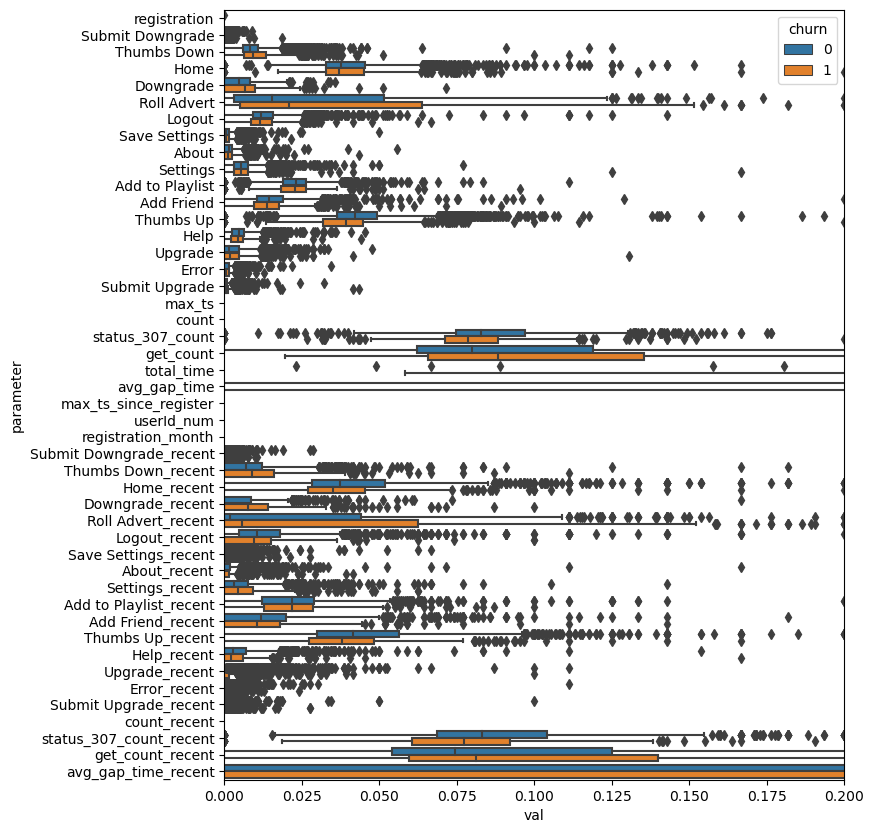

In [231]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp_change.drop(columns=['registration_dt']))
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([0,0.2])

In [232]:
df_model = pd.get_dummies(df_feats_tmp_change, columns=['agent', 'gender','first_level','last_level'], drop_first=True, dtype=int)
X, y = df_model.drop(columns=['userId', 'churn', 'location', 'state', 'registration_dt']).values, df_model.churn.values
feats = df_model.drop(columns=['userId', 'churn', 'location', 'state', 'registration_dt']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [233]:
clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                   param_grid = {'min_samples_leaf':[1,2,5,7,10,20,30,40,50]},
                   cv = 5,
                   scoring = ['f1', 'roc_auc'],
                   refit = 'f1',
                   verbose = 3)

In [234]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END min_samples_leaf=1; f1: (test=0.765) roc_auc: (test=0.934) total time=   0.5s
[CV 2/5] END min_samples_leaf=1; f1: (test=0.814) roc_auc: (test=0.926) total time=   0.5s
[CV 3/5] END min_samples_leaf=1; f1: (test=0.788) roc_auc: (test=0.942) total time=   0.5s
[CV 4/5] END min_samples_leaf=1; f1: (test=0.730) roc_auc: (test=0.925) total time=   0.5s
[CV 5/5] END min_samples_leaf=1; f1: (test=0.783) roc_auc: (test=0.961) total time=   0.5s
[CV 1/5] END min_samples_leaf=2; f1: (test=0.797) roc_auc: (test=0.944) total time=   0.5s
[CV 2/5] END min_samples_leaf=2; f1: (test=0.814) roc_auc: (test=0.937) total time=   0.5s
[CV 3/5] END min_samples_leaf=2; f1: (test=0.848) roc_auc: (test=0.936) total time=   0.5s
[CV 4/5] END min_samples_leaf=2; f1: (test=0.750) roc_auc: (test=0.923) total time=   0.5s
[CV 5/5] END min_samples_leaf=2; f1: (test=0.779) roc_auc: (test=0.963) total time=   0.5s
[CV 1/5] END min_samples_leaf=

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_leaf': [1, 2, 5, 7, 10, 20, 30, 40, 50]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=3)

In [235]:
clf.best_params_

{'min_samples_leaf': 5}

In [236]:
clf.cv_results_

{'mean_fit_time': array([0.50529547, 0.46611967, 0.43571525, 0.43016567, 0.39951472,
        0.35353074, 0.34844384, 0.32382288, 0.31261477]),
 'std_fit_time': array([0.01538853, 0.00441272, 0.00851924, 0.01415005, 0.00969587,
        0.00460873, 0.01854262, 0.00784061, 0.01946447]),
 'mean_score_time': array([0.01989717, 0.01929741, 0.01888762, 0.02020555, 0.01839514,
        0.01862097, 0.01975236, 0.01947031, 0.01846681]),
 'std_score_time': array([0.00087269, 0.00024214, 0.00046546, 0.00137291, 0.00036896,
        0.00079678, 0.00145983, 0.00105099, 0.00060828]),
 'param_min_samples_leaf': masked_array(data=[1, 2, 5, 7, 10, 20, 30, 40, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_leaf': 1},
  {'min_samples_leaf': 2},
  {'min_samples_leaf': 5},
  {'min_samples_leaf': 7},
  {'min_samples_leaf': 10},
  {'min_samples_leaf': 20},
  {'min_samples_l

In [237]:
f1_score(clf.predict(X_test), y_test)

0.8541666666666667

In [238]:
clf = GridSearchCV(pipeline,
                   param_grid = {'clf__C':[1e-2,1e-1,1.0,10.0,20.0]},
                   cv = 5,
                   scoring = ['f1', 'roc_auc'],
                   refit = 'f1',
                   verbose = 3)

In [239]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END clf__C=0.01; f1: (test=0.791) roc_auc: (test=0.934) total time=   0.2s
[CV 2/5] END clf__C=0.01; f1: (test=0.763) roc_auc: (test=0.930) total time=   0.2s
[CV 3/5] END clf__C=0.01; f1: (test=0.782) roc_auc: (test=0.934) total time=   0.2s
[CV 4/5] END clf__C=0.01; f1: (test=0.727) roc_auc: (test=0.935) total time=   0.2s
[CV 5/5] END clf__C=0.01; f1: (test=0.796) roc_auc: (test=0.951) total time=   0.2s
[CV 1/5] END clf__C=0.1; f1: (test=0.796) roc_auc: (test=0.938) total time=   0.2s
[CV 2/5] END clf__C=0.1; f1: (test=0.763) roc_auc: (test=0.930) total time=   0.2s
[CV 3/5] END clf__C=0.1; f1: (test=0.780) roc_auc: (test=0.941) total time=   0.2s
[CV 4/5] END clf__C=0.1; f1: (test=0.734) roc_auc: (test=0.940) total time=   0.2s
[CV 5/5] END clf__C=0.1; f1: (test=0.781) roc_auc: (test=0.954) total time=   0.2s
[CV 1/5] END clf__C=1.0; f1: (test=0.798) roc_auc: (test=0.938) total time=   0.2s
[CV 2/5] END clf__C=1.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', PowerTransformer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'clf__C': [0.01, 0.1, 1.0, 10.0, 20.0]}, refit='f1',
             scoring=['f1', 'roc_auc'], verbose=3)

In [240]:
f1_score(clf.predict(X_test), y_test)

0.8076923076923076

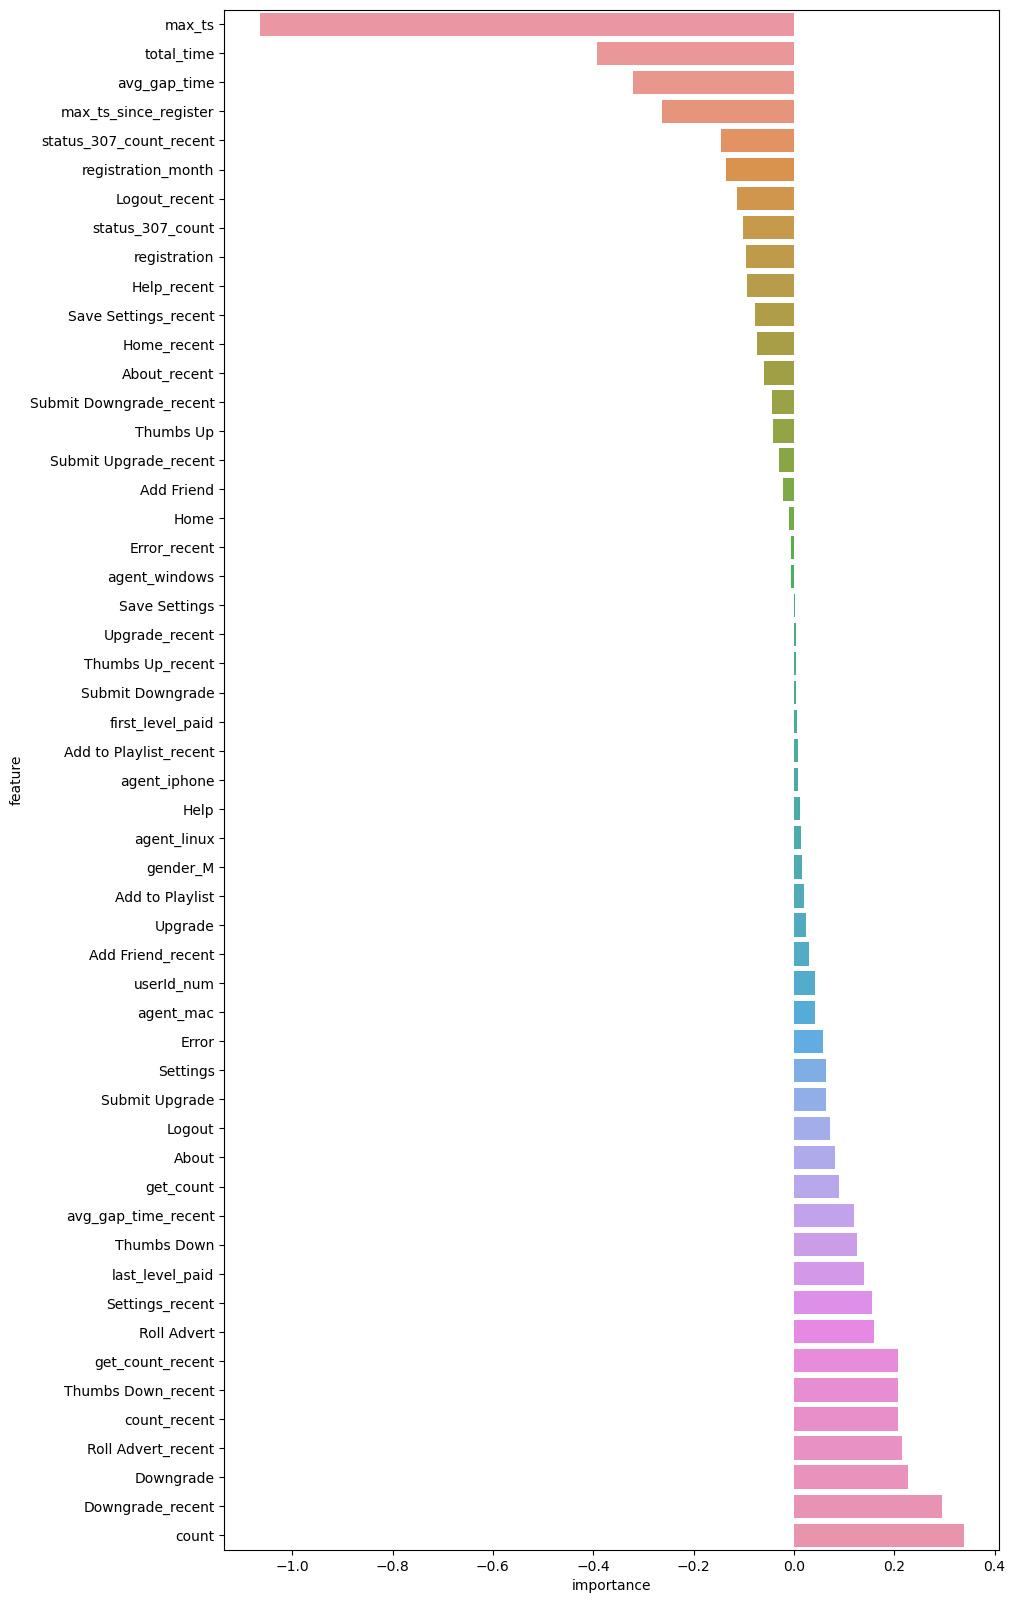

In [241]:
importance_plot(clf.best_estimator_[1].coef_, feats)

In [242]:
cols = [x for x in df_feats_tmp_change.columns if f"{x}_recent" in df_feats_tmp_change.columns]
for col in cols:
    df_feats_tmp_change[f"{col}_recent"] = df_feats_tmp_change[f"{col}_recent"] - df_feats_tmp_change[col]

In [243]:
df_model = pd.get_dummies(df_feats_tmp_change, columns=['agent', 'gender','first_level','last_level'], drop_first=True, dtype=int)
X, y = df_model.drop(columns=['userId', 'churn', 'location', 'state', 'registration_dt']).values, df_model.churn.values
feats = df_model.drop(columns=['userId', 'churn', 'location', 'state', 'registration_dt']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

(-0.05, 0.05)

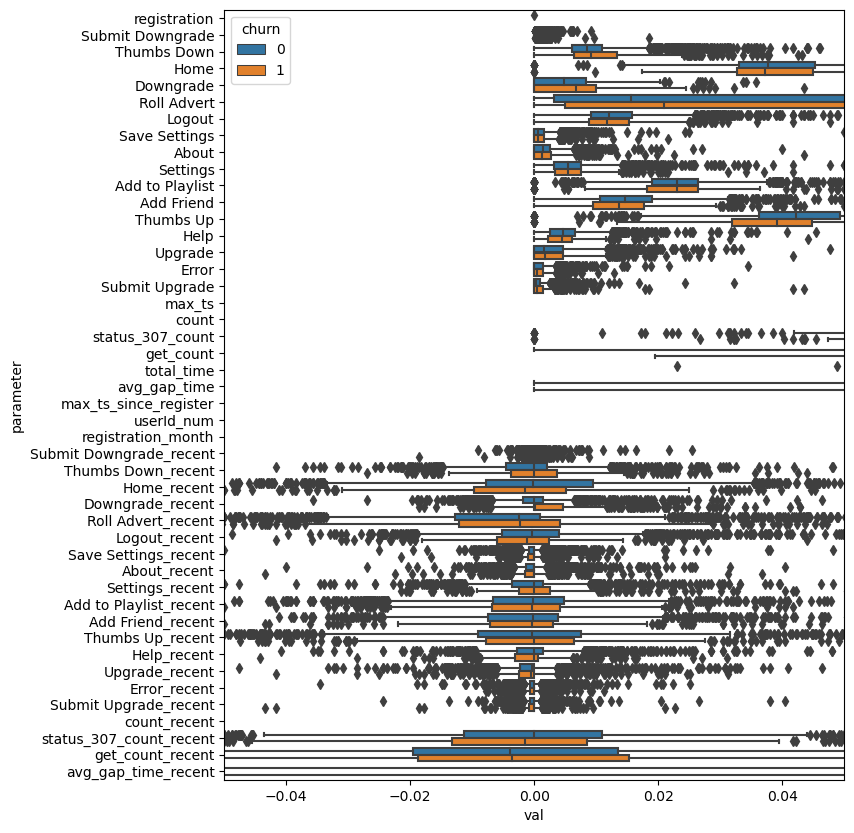

In [248]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp_change.drop(columns=['registration_dt']))
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([-0.05,0.05])

In [249]:
clf = GridSearchCV(pipeline,
                   param_grid = {'clf__C':[1e-3,1e-2,1e-1,1.0,10.0,20.0]},
                   cv = 5,
                   scoring = ['f1', 'roc_auc'],
                   refit = 'f1',
                   verbose = 3)

In [250]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END clf__C=0.001; f1: (test=0.733) roc_auc: (test=0.910) total time=   0.2s
[CV 2/5] END clf__C=0.001; f1: (test=0.762) roc_auc: (test=0.920) total time=   0.2s
[CV 3/5] END clf__C=0.001; f1: (test=0.775) roc_auc: (test=0.917) total time=   0.2s
[CV 4/5] END clf__C=0.001; f1: (test=0.729) roc_auc: (test=0.914) total time=   0.2s
[CV 5/5] END clf__C=0.001; f1: (test=0.778) roc_auc: (test=0.938) total time=   0.2s
[CV 1/5] END clf__C=0.01; f1: (test=0.758) roc_auc: (test=0.928) total time=   0.2s
[CV 2/5] END clf__C=0.01; f1: (test=0.788) roc_auc: (test=0.931) total time=   0.2s
[CV 3/5] END clf__C=0.01; f1: (test=0.784) roc_auc: (test=0.927) total time=   0.2s
[CV 4/5] END clf__C=0.01; f1: (test=0.713) roc_auc: (test=0.931) total time=   0.2s
[CV 5/5] END clf__C=0.01; f1: (test=0.780) roc_auc: (test=0.949) total time=   0.2s
[CV 1/5] END clf__C=0.1; f1: (test=0.789) roc_auc: (test=0.938) total time=   0.2s
[CV 2/5] END

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', PowerTransformer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1.0, 10.0, 20.0]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=3)

In [251]:
clf.best_params_

{'clf__C': 0.1}

In [252]:
clf.cv_results_

{'mean_fit_time': array([0.19149427, 0.1988255 , 0.19730535, 0.21805897, 0.2174253 ,
        0.21609774]),
 'std_fit_time': array([0.01239988, 0.01412071, 0.00569538, 0.02172893, 0.01399455,
        0.01704207]),
 'mean_score_time': array([0.01169481, 0.01177292, 0.012781  , 0.01319857, 0.01382737,
        0.01400781]),
 'std_score_time': array([0.00054796, 0.00074144, 0.0011349 , 0.00193824, 0.00192533,
        0.0015026 ]),
 'param_clf__C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 20.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__C': 0.001},
  {'clf__C': 0.01},
  {'clf__C': 0.1},
  {'clf__C': 1.0},
  {'clf__C': 10.0},
  {'clf__C': 20.0}],
 'split0_test_f1': array([0.73333333, 0.75824176, 0.78888889, 0.7752809 , 0.77094972,
        0.77094972]),
 'split1_test_f1': array([0.76190476, 0.78823529, 0.77647059, 0.75862069, 0.76136364,
        0.76136364]),
 'split2_test_f1': array([0.77456647,

In [253]:
f1_score(clf.predict(X_test), y_test)

0.8256880733944955

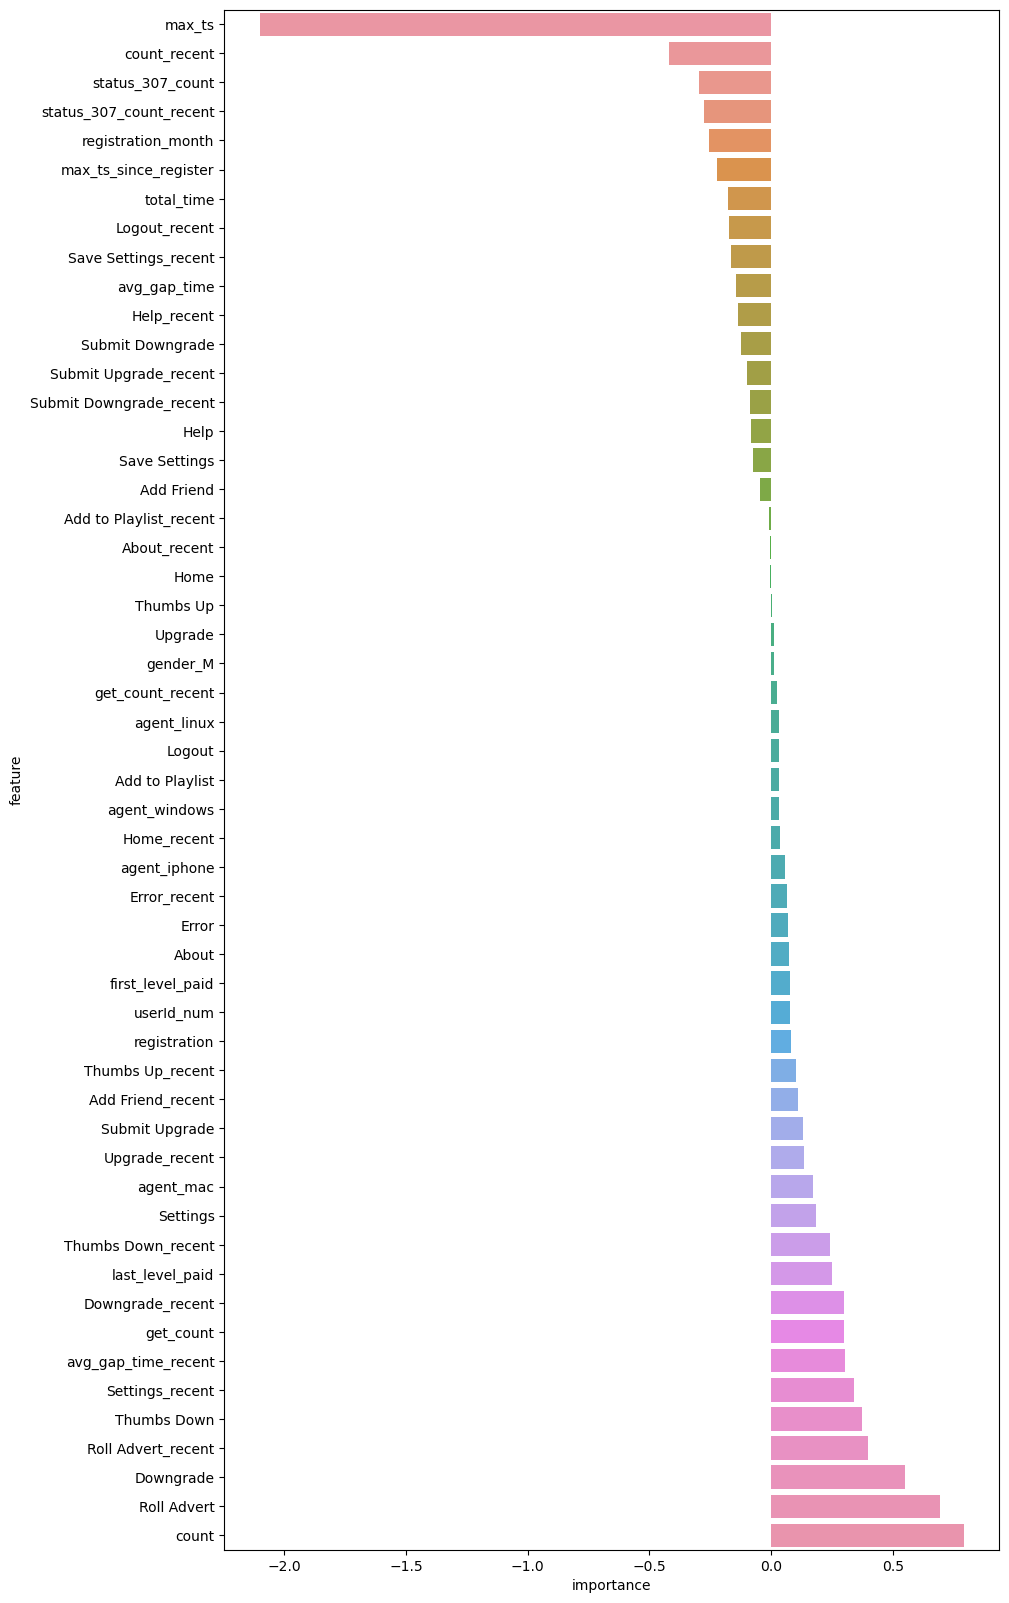

In [254]:
importance_plot(clf.best_estimator_[1].coef_, feats)

### 7. is using fewer features useful?

In [255]:
from scipy import stats

In [256]:
def ttest(dat1, dat2, min_count=10):
    if len(dat1) < min_count or len(dat2) < min_count:
        return np.nan
    else:
        return stats.ttest_ind(dat1, dat2)[1]

In [257]:
df_feats_tmp_change.dtypes

userId                             object
churn                               int32
location                           object
agent                              object
gender                             object
registration                      float64
Submit Downgrade                  float64
Thumbs Down                       float64
Home                              float64
Downgrade                         float64
Roll Advert                       float64
Logout                            float64
Save Settings                     float64
About                             float64
Settings                          float64
Add to Playlist                   float64
Add Friend                        float64
Thumbs Up                         float64
Help                              float64
Upgrade                           float64
Error                             float64
Submit Upgrade                    float64
max_ts                            float64
count                             

In [261]:
cols = list(df_feats_tmp_change.dtypes.index[df_feats_tmp_change.dtypes != 'object'])
cols.remove('churn')
cols.remove('registration_dt')
cols

['registration',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'max_ts',
 'count',
 'status_307_count',
 'get_count',
 'total_time',
 'avg_gap_time',
 'max_ts_since_register',
 'userId_num',
 'registration_month',
 'Submit Downgrade_recent',
 'Thumbs Down_recent',
 'Home_recent',
 'Downgrade_recent',
 'Roll Advert_recent',
 'Logout_recent',
 'Save Settings_recent',
 'About_recent',
 'Settings_recent',
 'Add to Playlist_recent',
 'Add Friend_recent',
 'Thumbs Up_recent',
 'Help_recent',
 'Upgrade_recent',
 'Error_recent',
 'Submit Upgrade_recent',
 'count_recent',
 'status_307_count_recent',
 'get_count_recent',
 'avg_gap_time_recent']

In [262]:
cols_not_selected = []
for col in cols:
    p = ttest(df_feats_tmp_change.loc[df_feats_tmp_change.churn==0, col].values,
              df_feats_tmp_change.loc[df_feats_tmp_change.churn==1, col].values)
    print(f"{col}: {p}")
    if p > 0.05:
        cols_not_selected.append(col)

registration: 0.12253098641756231
Submit Downgrade: 0.20873137942232092
Thumbs Down: 0.015876282353651714
Home: 0.18382891237624538
Downgrade: 3.074943870725991e-13
Roll Advert: 3.140037971300306e-11
Logout: 0.005830338423465807
Save Settings: 0.5477882770963356
About: 0.700726948082683
Settings: 0.16753186279703802
Add to Playlist: 0.685915298536957
Add Friend: 0.030301449787038866
Thumbs Up: 6.660908025082315e-11
Help: 0.045377978538479496
Upgrade: 0.12056612716119988
Error: 0.47441631834668263
Submit Upgrade: 0.00034495118039501595
max_ts: 2.429616387331441e-279
count: 0.7513042851458958
status_307_count: 3.30244642686875e-09
get_count: 5.141245464507829e-07
total_time: 1.9211909175069744e-121
avg_gap_time: 6.201861272174753e-37
max_ts_since_register: 3.389715629633745e-33
userId_num: 0.25813769691256616
registration_month: 0.09074271948676108
Submit Downgrade_recent: 0.4578397467606191
Thumbs Down_recent: 0.29406924730594414
Home_recent: 0.0042062448063504895
Downgrade_recent: 1.59

In [263]:
cols_not_selected

['registration',
 'Submit Downgrade',
 'Home',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Upgrade',
 'Error',
 'count',
 'userId_num',
 'registration_month',
 'Submit Downgrade_recent',
 'Thumbs Down_recent',
 'Save Settings_recent',
 'About_recent',
 'Add to Playlist_recent',
 'Add Friend_recent',
 'Thumbs Up_recent',
 'Help_recent',
 'Upgrade_recent',
 'Error_recent',
 'Submit Upgrade_recent',
 'count_recent',
 'get_count_recent']

In [264]:
df_feats_tmp_change_selected = df_feats_tmp_change.drop(columns=cols_not_selected)

In [265]:
df_feats_tmp_change.shape, df_feats_tmp_change_selected.shape

((2227, 55), (2227, 30))

In [266]:
df_model = pd.get_dummies(df_feats_tmp_change_selected, columns=['agent', 'gender','first_level','last_level'], drop_first=True, dtype=int)
X, y = df_model.drop(columns=['userId', 'churn', 'location', 'state', 'registration_dt']).values, df_model.churn.values
feats = df_model.drop(columns=['userId', 'churn', 'location', 'state', 'registration_dt']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [267]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END clf__C=0.001; f1: (test=0.714) roc_auc: (test=0.906) total time=   0.1s
[CV 2/5] END clf__C=0.001; f1: (test=0.739) roc_auc: (test=0.916) total time=   0.1s
[CV 3/5] END clf__C=0.001; f1: (test=0.749) roc_auc: (test=0.905) total time=   0.1s
[CV 4/5] END clf__C=0.001; f1: (test=0.713) roc_auc: (test=0.906) total time=   0.1s
[CV 5/5] END clf__C=0.001; f1: (test=0.773) roc_auc: (test=0.933) total time=   0.1s
[CV 1/5] END clf__C=0.01; f1: (test=0.729) roc_auc: (test=0.924) total time=   0.1s
[CV 2/5] END clf__C=0.01; f1: (test=0.769) roc_auc: (test=0.931) total time=   0.1s
[CV 3/5] END clf__C=0.01; f1: (test=0.766) roc_auc: (test=0.926) total time=   0.1s
[CV 4/5] END clf__C=0.01; f1: (test=0.685) roc_auc: (test=0.917) total time=   0.1s
[CV 5/5] END clf__C=0.01; f1: (test=0.777) roc_auc: (test=0.941) total time=   0.1s
[CV 1/5] END clf__C=0.1; f1: (test=0.736) roc_auc: (test=0.939) total time=   0.1s
[CV 2/5] END

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', PowerTransformer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1.0, 10.0, 20.0]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=3)

In [268]:
clf.best_params_

{'clf__C': 10.0}

In [269]:
f1_score(clf.predict(X_test), y_test)

0.7981220657276995

In [270]:
clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                   param_grid = {'min_samples_leaf':[1,2,5,7,10,20,30,40,50]},
                   cv = 5,
                   scoring = ['f1', 'roc_auc'],
                   refit = 'f1',
                   verbose = 3)

In [271]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END min_samples_leaf=1; f1: (test=0.752) roc_auc: (test=0.934) total time=   0.4s
[CV 2/5] END min_samples_leaf=1; f1: (test=0.780) roc_auc: (test=0.928) total time=   0.4s
[CV 3/5] END min_samples_leaf=1; f1: (test=0.855) roc_auc: (test=0.940) total time=   0.4s
[CV 4/5] END min_samples_leaf=1; f1: (test=0.734) roc_auc: (test=0.926) total time=   0.4s
[CV 5/5] END min_samples_leaf=1; f1: (test=0.764) roc_auc: (test=0.952) total time=   0.4s
[CV 1/5] END min_samples_leaf=2; f1: (test=0.787) roc_auc: (test=0.932) total time=   0.4s
[CV 2/5] END min_samples_leaf=2; f1: (test=0.819) roc_auc: (test=0.925) total time=   0.4s
[CV 3/5] END min_samples_leaf=2; f1: (test=0.868) roc_auc: (test=0.943) total time=   0.4s
[CV 4/5] END min_samples_leaf=2; f1: (test=0.767) roc_auc: (test=0.927) total time=   0.4s
[CV 5/5] END min_samples_leaf=2; f1: (test=0.797) roc_auc: (test=0.950) total time=   0.4s
[CV 1/5] END min_samples_leaf=

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_leaf': [1, 2, 5, 7, 10, 20, 30, 40, 50]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=3)

In [272]:
clf.best_params_

{'min_samples_leaf': 5}

In [273]:
f1_score(clf.predict(X_test), y_test)

0.837696335078534

### I guess getting f1_score around 0.83 is the best for now, not bad at all

In [274]:
spark.stop()

In [275]:
df_feats_tmp_change_selected

,userId,churn,location,agent,gender,Thumbs Down,Downgrade,Roll Advert,Logout,Add Friend,...,max_ts_since_register,registration_dt,state,Home_recent,Downgrade_recent,Roll Advert_recent,Logout_recent,Settings_recent,status_307_count_recent,avg_gap_time_recent
0,1222580,1,"Watertown, SD",mac,M,0.007867,0.007404,0.007867,0.011106,0.016196,...,1820.773611,2018-08-16 02:31:00,SD,0.007358,-0.005116,0.012728,-0.006529,0.001775,-0.008166,2.403884
1,1199968,0,"Albany, OR",windows,F,0.010758,0.010513,0.003912,0.009291,0.013447,...,1585.354722,2018-09-25 15:15:32,OR,-0.003572,0.003395,-0.002521,-0.002337,0.007796,0.010208,17.648665
2,1122089,0,"Chicago-Naperville-Elgin, IL-IN-WI",windows,F,0.010000,0.009355,0.000645,0.010968,0.011613,...,1891.833611,2018-09-12 21:43:56,IL,-0.000938,0.001688,-0.000645,0.001302,-0.001803,0.012405,-30.825861
3,1418529,1,"Phoenix-Mesa-Scottsdale, AZ",windows,F,0.008139,0.010946,0.003929,0.011226,0.015998,...,1215.827500,2018-09-21 19:27:33,AZ,0.005383,0.004679,-0.002813,0.003282,-0.001697,0.003162,-4.861816
4,1957869,0,"San Jose-Sunnyvale-Santa Clara, CA",windows,F,0.009714,0.009714,0.001143,0.010286,0.017714,...,4265.084722,2018-06-05 14:31:59,CA,-0.001109,-0.003797,0.000041,-0.000818,0.001386,0.001697,-52.235556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,1649197,0,"Washington-Arlington-Alexandria, DC-VA-MD-WV",mac,F,0.018182,0.000000,0.063636,0.000000,0.000000,...,-61.177778,2018-11-10 10:55:15,DC,0.018855,0.000000,-0.026599,0.000000,0.027946,0.048148,0.000000
2223,1087484,0,"Chico, CA",windows,F,0.018868,0.000000,0.000000,0.000000,0.000000,...,1567.732500,2018-09-11 23:59:17,CA,-0.018868,0.000000,0.000000,0.000000,-0.018868,-0.094340,0.000000
2224,1160957,0,"Allentown-Bethlehem-Easton, PA-NJ",windows,M,0.019231,0.000000,0.057692,0.019231,0.019231,...,1499.569444,2018-09-19 10:17:25,PA,-0.007692,0.000000,-0.007692,-0.019231,0.000000,0.015385,0.000000
2225,1364857,0,"Los Angeles-Long Beach-Anaheim, CA",windows,M,0.012903,0.000000,0.032258,0.032258,0.019355,...,1841.832500,2018-09-14 00:50:46,CA,-0.002002,0.000000,-0.004672,0.002225,0.000445,0.008899,-38.997500


In [276]:
df_model = pd.get_dummies(df_feats_tmp_change_selected, columns=['agent', 'gender','first_level','last_level','state'], drop_first=True, dtype=int)
X, y = df_model.drop(columns=['userId', 'churn', 'location','registration_dt']).values, df_model.churn.values
feats = df_model.drop(columns=['userId', 'churn', 'location','registration_dt']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [277]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END min_samples_leaf=1; f1: (test=0.752) roc_auc: (test=0.925) total time=   0.4s
[CV 2/5] END min_samples_leaf=1; f1: (test=0.765) roc_auc: (test=0.927) total time=   0.4s
[CV 3/5] END min_samples_leaf=1; f1: (test=0.809) roc_auc: (test=0.952) total time=   0.3s
[CV 4/5] END min_samples_leaf=1; f1: (test=0.750) roc_auc: (test=0.923) total time=   0.3s
[CV 5/5] END min_samples_leaf=1; f1: (test=0.772) roc_auc: (test=0.954) total time=   0.4s
[CV 1/5] END min_samples_leaf=2; f1: (test=0.763) roc_auc: (test=0.931) total time=   0.3s
[CV 2/5] END min_samples_leaf=2; f1: (test=0.800) roc_auc: (test=0.931) total time=   0.3s
[CV 3/5] END min_samples_leaf=2; f1: (test=0.853) roc_auc: (test=0.952) total time=   0.3s
[CV 4/5] END min_samples_leaf=2; f1: (test=0.791) roc_auc: (test=0.919) total time=   0.3s
[CV 5/5] END min_samples_leaf=2; f1: (test=0.797) roc_auc: (test=0.957) total time=   0.3s
[CV 1/5] END min_samples_leaf=

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_leaf': [1, 2, 5, 7, 10, 20, 30, 40, 50]},
             refit='f1', scoring=['f1', 'roc_auc'], verbose=3)

In [280]:
clf.best_score_, clf.best_params_

(0.8009666602973752, {'min_samples_leaf': 2})

In [279]:
f1_score(clf.predict(X_test), y_test)

0.8461538461538461

In [281]:
clf = GridSearchCV(pipeline,
                   param_grid = {'clf__C':[1e-2,1e-1,1.0,5.0,10.0,20]},
                   cv = 4,
                   scoring = ['f1', 'roc_auc'],
                   refit = 'f1',
                   verbose = 3)

In [282]:
clf.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END clf__C=0.01; f1: (test=0.722) roc_auc: (test=0.911) total time=   0.2s
[CV 2/4] END clf__C=0.01; f1: (test=0.720) roc_auc: (test=0.921) total time=   0.3s
[CV 3/4] END clf__C=0.01; f1: (test=0.709) roc_auc: (test=0.901) total time=   0.3s
[CV 4/4] END clf__C=0.01; f1: (test=0.777) roc_auc: (test=0.941) total time=   0.3s
[CV 1/4] END clf__C=0.1; f1: (test=0.740) roc_auc: (test=0.923) total time=   0.3s
[CV 2/4] END clf__C=0.1; f1: (test=0.747) roc_auc: (test=0.923) total time=   0.3s
[CV 3/4] END clf__C=0.1; f1: (test=0.729) roc_auc: (test=0.910) total time=   0.2s
[CV 4/4] END clf__C=0.1; f1: (test=0.775) roc_auc: (test=0.946) total time=   0.3s
[CV 1/4] END clf__C=1.0; f1: (test=0.735) roc_auc: (test=0.922) total time=   0.3s
[CV 2/4] END clf__C=1.0; f1: (test=0.750) roc_auc: (test=0.920) total time=   0.3s
[CV 3/4] END clf__C=1.0; f1: (test=0.729) roc_auc: (test=0.914) total time=   0.3s
[CV 4/4] END clf__C=1.0

/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END clf__C=10.0; f1: (test=0.722) roc_auc: (test=0.913) total time=   0.3s
[CV 2/4] END clf__C=10.0; f1: (test=0.750) roc_auc: (test=0.920) total time=   0.3s
[CV 3/4] END clf__C=10.0; f1: (test=0.739) roc_auc: (test=0.915) total time=   0.3s
[CV 4/4] END clf__C=10.0; f1: (test=0.764) roc_auc: (test=0.932) total time=   0.3s


/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END clf__C=20; f1: (test=0.722) roc_auc: (test=0.909) total time=   0.3s


/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END clf__C=20; f1: (test=0.747) roc_auc: (test=0.920) total time=   0.3s


/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END clf__C=20; f1: (test=0.739) roc_auc: (test=0.915) total time=   0.3s


/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END clf__C=20; f1: (test=0.764) roc_auc: (test=0.929) total time=   0.3s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocess', PowerTransformer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'clf__C': [0.01, 0.1, 1.0, 5.0, 10.0, 20]}, refit='f1',
             scoring=['f1', 'roc_auc'], verbose=3)

In [283]:
clf.best_params_

{'clf__C': 0.1}

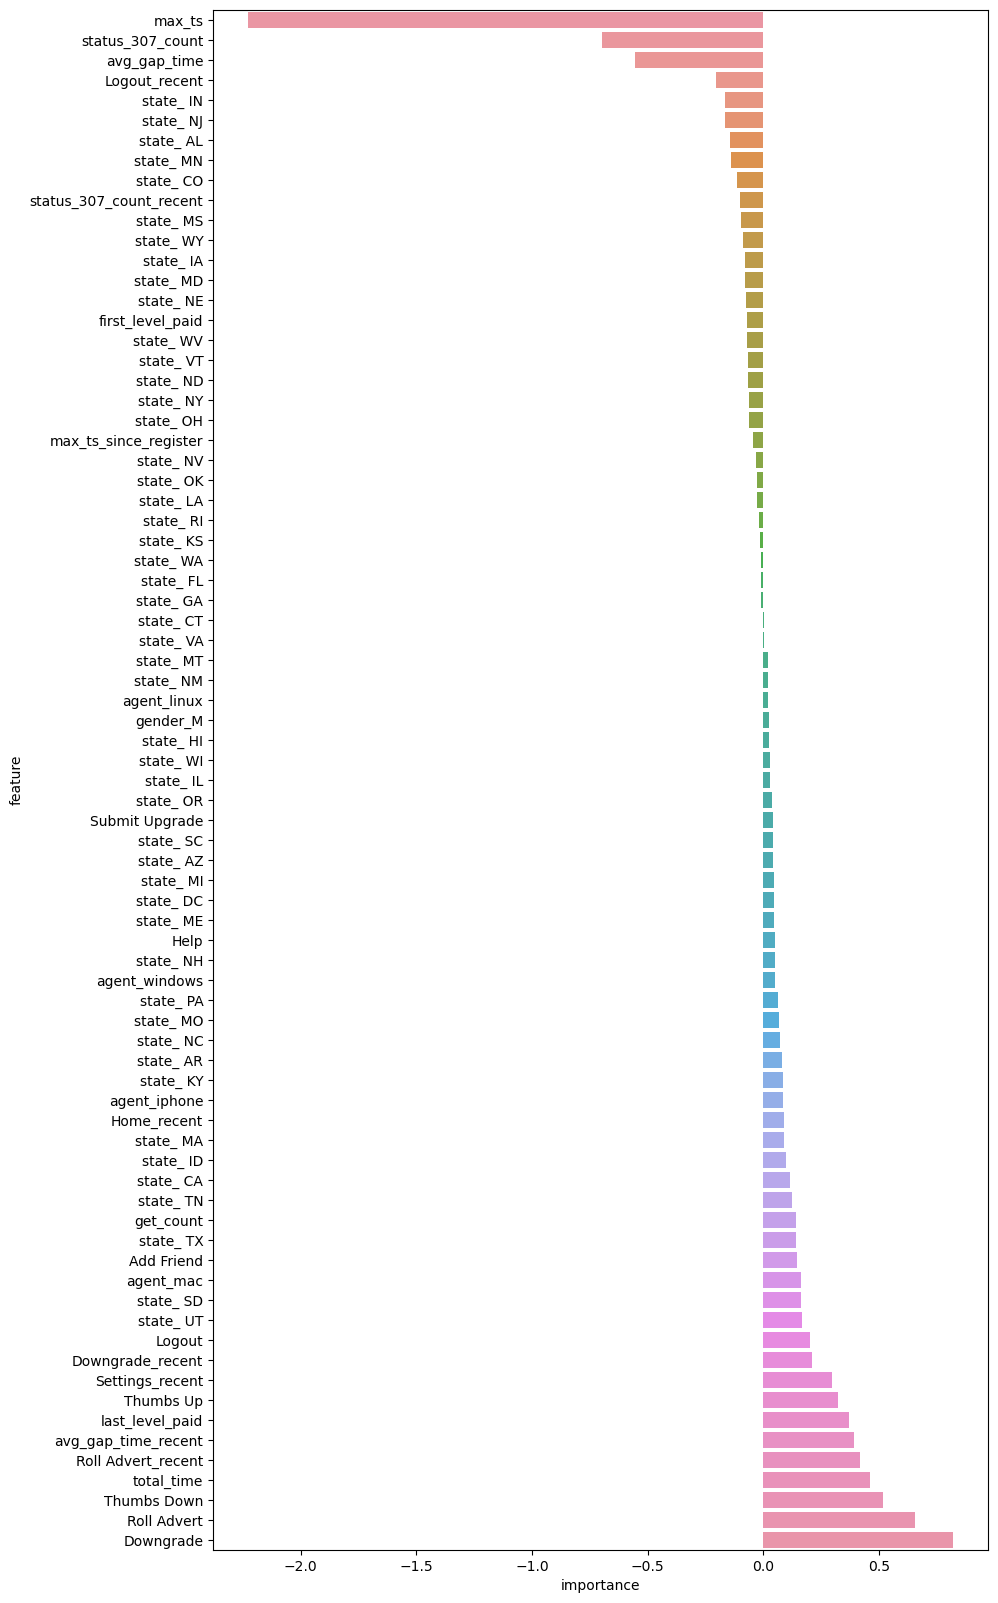

In [284]:
importance_plot(clf.best_estimator_[1].coef_, feats)

#### there may be some importances in the state, but not really improving the fit